<a href="https://colab.research.google.com/github/ParisaKalaki/PCOS-Detection/blob/main/Modelling_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pointbiserialr, spearmanr, chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, classification_report, make_scorer, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid, cross_validate, cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
import plotly.graph_objects as go
import plotly.subplots as sp


In [ ]:
file_path_with_infertility = "https://drive.google.com/uc?id=1hb-vYxJOjVlYu747eD5TEmzLDSnZ9PYl"
file_path_without_infertility = "https://docs.google.com/spreadsheets/d/1_tuPLLCvzccMdTRyiIOusbosPpThCqWl/export?format=xlsx"
PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

In [ ]:
data = pd.merge(PCOS_woinf,PCOS_inf, on='Patient File No.', suffixes=('','_y'),how='left')

print(data.shape)

#Dropping the repeated features after merging
data =data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y','II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

(541, 50)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Cleaning

In [ ]:
data.columns

Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', ' Age (yrs)', 'Weight (Kg)',
       'Height(Cm) ', 'BMI', 'Blood Group', 'Pulse rate(bpm) ',
       'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)',
       'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions',
       '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)',
       'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)',
       'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)',
       'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)'],
      dtype='object')

In [ ]:
print(data.dtypes)


Sl. No                      int64
Patient File No.            int64
PCOS (Y/N)                  int64
 Age (yrs)                  int64
Weight (Kg)               float64
Height(Cm)                float64
BMI                       float64
Blood Group                 int64
Pulse rate(bpm)             int64
RR (breaths/min)            int64
Hb(g/dl)                  float64
Cycle(R/I)                  int64
Cycle length(days)          int64
Marraige Status (Yrs)     float64
Pregnant(Y/N)               int64
No. of aborptions           int64
  I   beta-HCG(mIU/mL)    float64
II    beta-HCG(mIU/mL)     object
FSH(mIU/mL)               float64
LH(mIU/mL)                float64
FSH/LH                    float64
Hip(inch)                   int64
Waist(inch)                 int64
Waist:Hip Ratio           float64
TSH (mIU/L)               float64
AMH(ng/mL)                 object
PRL(ng/mL)                float64
Vit D3 (ng/mL)            float64
PRG(ng/mL)                float64
RBS(mg/dl)    

In [ ]:
data.head()

Sl. No  Patient File No.  PCOS (Y/N)   Age (yrs)  Weight (Kg)  Height(Cm)   \
0       1                 1           0          28         44.6        152.0   
1       2                 2           0          36         65.0        161.5   
2       3                 3           1          33         68.8        165.0   
3       4                 4           0          37         65.0        148.0   
4       5                 5           0          25         52.0        161.0   

         BMI  Blood Group  Pulse rate(bpm)   RR (breaths/min)  ...  \
0  19.300000           15                78                22  ...   
1  24.921163           15                74                20  ...   
2  25.270891           11                72                18  ...   
3  29.674945           13                72                20  ...   
4  20.060954           11                72                18  ...   

   Pimples(Y/N)  Fast food (Y/N)  Reg.Exercise(Y/N)  BP _Systolic (mmHg)  \
0             0              1.0                  0                  110   
1             0              0.0                  0                  120   
2             1              1.0                  0                  120   
3             0              0.0                  0                  120   
4             0              0.0                  0                  120   

   BP _Diastolic (mmHg)  Follicle No. (L)  Follicle No. (R)  \
0                    80                 3                 3   
1                    70                 3                 5   
2                    80                13                15   
3                    70                 2                 2   
4                    80                 3                 4   

  Avg. F size (L) (mm)  Avg. F size (R) (mm)  Endometrium (mm)  
0                 18.0                  18.0               8.5  
1                 15.0                  14.0               3.7  
2                 18.0                  20.0              10.0  
3                 15.0                  14.0               7.5  
4                 16.0                  14.0               7.0  

[5 rows x 44 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

* Checking for duplicate values

In [ ]:
data[data.duplicated()]

Empty DataFrame
Columns: [Sl. No, Patient File No., PCOS (Y/N),  Age (yrs), Weight (Kg), Height(Cm) , BMI, Blood Group, Pulse rate(bpm) , RR (breaths/min), Hb(g/dl), Cycle(R/I), Cycle length(days), Marraige Status (Yrs), Pregnant(Y/N), No. of aborptions,   I   beta-HCG(mIU/mL), II    beta-HCG(mIU/mL), FSH(mIU/mL), LH(mIU/mL), FSH/LH, Hip(inch), Waist(inch), Waist:Hip Ratio, TSH (mIU/L), AMH(ng/mL), PRL(ng/mL), Vit D3 (ng/mL), PRG(ng/mL), RBS(mg/dl), Weight gain(Y/N), hair growth(Y/N), Skin darkening (Y/N), Hair loss(Y/N), Pimples(Y/N), Fast food (Y/N), Reg.Exercise(Y/N), BP _Systolic (mmHg), BP _Diastolic (mmHg), Follicle No. (L), Follicle No. (R), Avg. F size (L) (mm), Avg. F size (R) (mm), Endometrium (mm)]
Index: []

[0 rows x 44 columns]

In [ ]:
# finding all the data types present in the dataset
dtype_info = data.dtypes
unique_dtype_info=set(dtype_info)
unique_dtype_info

{dtype('int64'), dtype('float64'), dtype('O')}

In [ ]:
# Columns with numerical datatype
numerical_column_names= list(data.select_dtypes(include=['int64','float64']).columns)
len(numerical_column_names)

42

In [ ]:
# Columns with object datatypes
object_column_names= list(data.select_dtypes(include=['object']).columns)
len(object_column_names)

2

In [ ]:
for names in object_column_names:
    print(data[names].head())


0      1.99
1      1.99
2    494.08
3      1.99
4    801.45
Name: II    beta-HCG(mIU/mL), dtype: object
0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL), dtype: object


 * the data has numeric values saved as strings

In [ ]:
# Find columns with missing values
columns_with_missing = list(data.columns[data.isnull().any()])
print("Columns with missing values:", columns_with_missing)


Columns with missing values: ['Marraige Status (Yrs)', 'Fast food (Y/N)']


# EDA


In [ ]:
#!pip install ydata_profiling

In [ ]:
#from ydata_profiling import ProfileReport

#profile = ProfileReport(df, title="EDA Report", explorative=True)
#profile.to_notebook_iframe()


### There are two types of feature
* Numerical (int, float)
* Categorical ( Object)

### First we will check the Categorical features

In [ ]:
df=data.copy()

In [ ]:
categorical_features=df[object_column_names]
categorical_features.isnull().sum()

II    beta-HCG(mIU/mL)    0
AMH(ng/mL)                0
dtype: int64

In [ ]:
categorical_features.head()

II    beta-HCG(mIU/mL) AMH(ng/mL)
0                   1.99       2.07
1                   1.99       1.53
2                 494.08       6.63
3                   1.99       1.22
4                 801.45       2.26

* both the above features can be convertedt numerical features

In [ ]:
print(pd.to_numeric(df['AMH(ng/mL)'],errors='coerce').isnull().sum())
print(pd.to_numeric(df['II    beta-HCG(mIU/mL)'],errors='coerce').isnull().sum())

1
1


* Replacing the incorrect values with the median and converting the column to numerical column

In [ ]:
for columns in object_column_names:
    df[columns] = pd.to_numeric(df[columns], errors='coerce')
    df[columns].fillna(df[columns].median(),inplace=True)


<ipython-input-22-063d436911cf>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[columns].fillna(df[columns].median(),inplace=True)


In [ ]:
print(pd.to_numeric(df['AMH(ng/mL)'],errors='coerce').isnull().sum())
print(pd.to_numeric(df['II    beta-HCG(mIU/mL)'],errors='coerce').isnull().sum())

0
0


In [ ]:
print(df.dtypes)


Sl. No                      int64
Patient File No.            int64
PCOS (Y/N)                  int64
 Age (yrs)                  int64
Weight (Kg)               float64
Height(Cm)                float64
BMI                       float64
Blood Group                 int64
Pulse rate(bpm)             int64
RR (breaths/min)            int64
Hb(g/dl)                  float64
Cycle(R/I)                  int64
Cycle length(days)          int64
Marraige Status (Yrs)     float64
Pregnant(Y/N)               int64
No. of aborptions           int64
  I   beta-HCG(mIU/mL)    float64
II    beta-HCG(mIU/mL)    float64
FSH(mIU/mL)               float64
LH(mIU/mL)                float64
FSH/LH                    float64
Hip(inch)                   int64
Waist(inch)                 int64
Waist:Hip Ratio           float64
TSH (mIU/L)               float64
AMH(ng/mL)                float64
PRL(ng/mL)                float64
Vit D3 (ng/mL)            float64
PRG(ng/mL)                float64
RBS(mg/dl)    

In [ ]:
numerical_column_names= list(df.select_dtypes(include=['int64','float64']).columns)
len(numerical_column_names)

44

* exploring numerical values

In [ ]:
df[numerical_column_names].isnull().sum()

Sl. No                    0
Patient File No.          0
PCOS (Y/N)                0
 Age (yrs)                0
Weight (Kg)               0
Height(Cm)                0
BMI                       0
Blood Group               0
Pulse rate(bpm)           0
RR (breaths/min)          0
Hb(g/dl)                  0
Cycle(R/I)                0
Cycle length(days)        0
Marraige Status (Yrs)     1
Pregnant(Y/N)             0
No. of aborptions         0
  I   beta-HCG(mIU/mL)    0
II    beta-HCG(mIU/mL)    0
FSH(mIU/mL)               0
LH(mIU/mL)                0
FSH/LH                    0
Hip(inch)                 0
Waist(inch)               0
Waist:Hip Ratio           0
TSH (mIU/L)               0
AMH(ng/mL)                0
PRL(ng/mL)                0
Vit D3 (ng/mL)            0
PRG(ng/mL)                0
RBS(mg/dl)                0
Weight gain(Y/N)          0
hair growth(Y/N)          0
Skin darkening (Y/N)      0
Hair loss(Y/N)            0
Pimples(Y/N)              0
Fast food (Y/N)           1
Reg.Exercise(Y/N)         0
BP _Systolic (mmHg)       0
BP _Diastolic (mmHg)      0
Follicle No. (L)          0
Follicle No. (R)          0
Avg. F size (L) (mm)      0
Avg. F size (R) (mm)      0
Endometrium (mm)          0
dtype: int64

In [ ]:
df['Marraige Status (Yrs)'].fillna(df['Marraige Status (Yrs)'].median(),inplace=True)
df['Fast food (Y/N)'].fillna(df['Fast food (Y/N)'].median(),inplace=True)


<ipython-input-27-3ac240d27e66>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Marraige Status (Yrs)'].fillna(df['Marraige Status (Yrs)'].median(),inplace=True)
<ipython-input-27-3ac240d27e66>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].m

In [ ]:
df.describe()

Sl. No  Patient File No.  PCOS (Y/N)   Age (yrs)  Weight (Kg)  \
count  541.000000        541.000000  541.000000  541.000000   541.000000   
mean   271.000000        271.000000    0.327172   31.430684    59.637153   
std    156.317519        156.317519    0.469615    5.411006    11.028287   
min      1.000000          1.000000    0.000000   20.000000    31.000000   
25%    136.000000        136.000000    0.000000   28.000000    52.000000   
50%    271.000000        271.000000    0.000000   31.000000    59.000000   
75%    406.000000        406.000000    1.000000   35.000000    65.000000   
max    541.000000        541.000000    1.000000   48.000000   108.000000   

       Height(Cm)          BMI  Blood Group  Pulse rate(bpm)   \
count   541.000000  541.000000   541.000000        541.000000   
mean    156.484835   24.311285    13.802218         73.247689   
std       6.033545    4.056399     1.840812          4.430285   
min     137.000000   12.417882    11.000000         13.000000   
25%     152.000000   21.641274    13.000000         72.000000   
50%     156.000000   24.238227    14.000000         72.000000   
75%     160.000000   26.634958    15.000000         74.000000   
max     180.000000   38.900000    18.000000         82.000000   

       RR (breaths/min)  ...  Pimples(Y/N)  Fast food (Y/N)  \
count        541.000000  ...    541.000000       541.000000   
mean          19.243993  ...      0.489834         0.515712   
std            1.688629  ...      0.500359         0.500216   
min           16.000000  ...      0.000000         0.000000   
25%           18.000000  ...      0.000000         0.000000   
50%           18.000000  ...      0.000000         1.000000   
75%           20.000000  ...      1.000000         1.000000   
max           28.000000  ...      1.000000         1.000000   

       Reg.Exercise(Y/N)  BP _Systolic (mmHg)  BP _Diastolic (mmHg)  \
count         541.000000           541.000000            541.000000   
mean            0.247689           114.661738             76.927911   
std             0.432070             7.384556              5.574112   
min             0.000000            12.000000              8.000000   
25%             0.000000           110.000000             70.000000   
50%             0.000000           110.000000             80.000000   
75%             0.000000           120.000000             80.000000   
max             1.000000           140.000000            100.000000   

       Follicle No. (L)  Follicle No. (R)  Avg. F size (L) (mm)  \
count        541.000000        541.000000            541.000000   
mean           6.129390          6.641405             15.018115   
std            4.229294          4.436889              3.566839   
min            0.000000          0.000000              0.000000   
25%            3.000000          3.000000             13.000000   
50%            5.000000          6.000000             15.000000   
75%            9.000000         10.000000             18.000000   
max           22.000000         20.000000             24.000000   

       Avg. F size (R) (mm)  Endometrium (mm)  
count            541.000000        541.000000  
mean              15.451701          8.475915  
std                3.318848          2.165381  
min                0.000000          0.000000  
25%               13.000000          7.000000  
50%               16.000000          8.500000  
75%               18.000000          9.800000  
max               24.000000         18.000000  

[8 rows x 44 columns]

In [ ]:
numerical_features= df[numerical_column_names]

In [ ]:
numerical_features.nunique()

Sl. No                    541
Patient File No.          541
PCOS (Y/N)                  2
 Age (yrs)                 29
Weight (Kg)               117
Height(Cm)                 50
BMI                       355
Blood Group                 8
Pulse rate(bpm)            11
RR (breaths/min)            8
Hb(g/dl)                   46
Cycle(R/I)                  3
Cycle length(days)         12
Marraige Status (Yrs)      34
Pregnant(Y/N)               2
No. of aborptions           6
  I   beta-HCG(mIU/mL)    307
II    beta-HCG(mIU/mL)    202
FSH(mIU/mL)               371
LH(mIU/mL)                342
FSH/LH                    512
Hip(inch)                  19
Waist(inch)                23
Waist:Hip Ratio            96
TSH (mIU/L)               308
AMH(ng/mL)                300
PRL(ng/mL)                481
Vit D3 (ng/mL)            331
PRG(ng/mL)                 89
RBS(mg/dl)                 55
Weight gain(Y/N)            2
hair growth(Y/N)            2
Skin darkening (Y/N)        2
Hair loss(Y/N)              2
Pimples(Y/N)                2
Fast food (Y/N)             2
Reg.Exercise(Y/N)           2
BP _Systolic (mmHg)         6
BP _Diastolic (mmHg)        5
Follicle No. (L)           21
Follicle No. (R)           20
Avg. F size (L) (mm)       31
Avg. F size (R) (mm)       32
Endometrium (mm)           91
dtype: int64

# dealing with outliers

In [ ]:
# Selecting the numerical columns from the df_clean to check for the outliers.
exp_df = df.copy()


In [ ]:
# checking for outliers

# Selecting relevant numerical columns
relevant_number_columns=exp_df.columns

outlier_counts = {}

for column in relevant_number_columns:
    Q1 = exp_df[column].quantile(0.25)
    Q3 = exp_df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    num_outliers = exp_df[(exp_df[column] < lower_bound) | (exp_df[column] > upper_bound)].shape[0]


    outlier_counts[column] = num_outliers


outlier_counts_exp_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Outlier Count'])
outlier_counts_exp_df

Outlier Count
Sl. No                              0
Patient File No.                    0
PCOS (Y/N)                          0
 Age (yrs)                          5
Weight (Kg)                        18
Height(Cm)                          6
BMI                                12
Blood Group                         0
Pulse rate(bpm)                    94
RR (breaths/min)                   14
Hb(g/dl)                            8
Cycle(R/I)                          0
Cycle length(days)                 77
Marraige Status (Yrs)              11
Pregnant(Y/N)                       0
No. of aborptions                 104
  I   beta-HCG(mIU/mL)             46
II    beta-HCG(mIU/mL)             78
FSH(mIU/mL)                        12
LH(mIU/mL)                         24
FSH/LH                             48
Hip(inch)                          21
Waist(inch)                        17
Waist:Hip Ratio                     0
TSH (mIU/L)                        27
AMH(ng/mL)                         52
PRL(ng/mL)                         21
Vit D3 (ng/mL)                     31
PRG(ng/mL)                         39
RBS(mg/dl)                         30
Weight gain(Y/N)                    0
hair growth(Y/N)                    0
Skin darkening (Y/N)                0
Hair loss(Y/N)                      0
Pimples(Y/N)                        0
Fast food (Y/N)                     0
Reg.Exercise(Y/N)                 134
BP _Systolic (mmHg)                 3
BP _Diastolic (mmHg)                2
Follicle No. (L)                    6
Follicle No. (R)                    0
Avg. F size (L) (mm)                9
Avg. F size (R) (mm)                5
Endometrium (mm)                    8

In [ ]:

# Define custom colors
custom_colors = ["#2A192C", "#5A2A42", "#BDB562", "#C1C6A8", "#967C41", "#971439"]

# Create a 3x5 grid layout
rows, cols =9, 5
fig = sp.make_subplots(rows=rows, cols=cols, subplot_titles=relevant_number_columns)

# Add boxplots to each grid cell
for i, column in enumerate(relevant_number_columns):
    row = (i // cols) + 1  # Calculate row index
    col = (i % cols) + 1   # Calculate column index

    fig.add_trace(
        go.Box(
            y=exp_df[column],
            name=column,
            marker_color=custom_colors[i % len(custom_colors)],  # Assign colors cyclically
            boxmean=True  # Show mean as a marker in the boxplot
        ),
        row=row,
        col=col
    )

# Update layout for titles and formatting
fig.update_layout(
    title="Interactive Boxplots for Numerical Columns (3x5 Grid)",
    height=1500,  # Adjust height for better visuals
    width=1200,  # Adjust width for better visuals
    showlegend=False,
    template="plotly_white",
    font=dict(color="#2E2E2E"),
    title_font=dict(size=16, color="#2E2E2E"),
)

# Show the interactive plot
fig.show()

In [ ]:


# Selecting relevant numerical columns
relevant_number_columns = exp_df.select_dtypes(include=['number']).columns

# Detecting outliers and storing them
outlier_rows = {}

for column in relevant_number_columns:
    Q1 = exp_df[column].quantile(0.25)
    Q3 = exp_df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtering rows where an outlier exists
    outlier_df = exp_df[(exp_df[column] < lower_bound) | (exp_df[column] > upper_bound)]

    outlier_rows[column] = outlier_df  # Store the full rows

# # Displaying each column's outlier rows
# for column, df in outlier_rows.items():
#     print(f"\nOutliers detected in column: {column}")
#     print(df)


In [ ]:
relevant_number_columns

Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', ' Age (yrs)', 'Weight (Kg)',
       'Height(Cm) ', 'BMI', 'Blood Group', 'Pulse rate(bpm) ',
       'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)',
       'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions',
       '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)',
       'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)',
       'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)',
       'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)'],
      dtype='object')

In [ ]:


# Calculate the mean of Pulse rate
pulse_mean = exp_df["BP _Diastolic (mmHg)"].mean()

# Replace values below 20 with the mean
exp_df["BP _Diastolic (mmHg)"] = exp_df["BP _Diastolic (mmHg)"].apply(lambda x: pulse_mean if x < 10 else x)




In [ ]:


# Calculate the mean
mean_val = exp_df["Pulse rate(bpm) "].mean()

# Replace values with the mean
exp_df["Pulse rate(bpm) "] = exp_df["Pulse rate(bpm) "].apply(lambda x: mean_val if x < 20 else x)




In [ ]:


# Calculate the mean
mean_val = exp_df['AMH(ng/mL)'].mean()

# Replace values  with the mean
exp_df['AMH(ng/mL)'] = exp_df['AMH(ng/mL)'].apply(lambda x: mean_val if x > 60 else x)




In [ ]:


# Calculate the mean
mean_val = exp_df["TSH (mIU/L)"].mean()

# Replace values  with the mean
exp_df["TSH (mIU/L)"] = exp_df["TSH (mIU/L)"].apply(lambda x: mean_val if x > 60 else x)




In [ ]:
# Calculate the mean
mean_val = exp_df['FSH(mIU/mL)'].mean()
# Replace values with the mean
exp_df['FSH(mIU/mL)'] = exp_df['FSH(mIU/mL)'].apply(lambda x: mean_val if x > 1000 else x)




In [ ]:


# Calculate the mean
mean_val = exp_df['RBS(mg/dl)'].mean()

# Replace values  with the mean
exp_df['RBS(mg/dl)'] = exp_df['RBS(mg/dl)'].apply(lambda x: mean_val if x > 300 else x)




In [ ]:
df=exp_df.copy()

## Correlation


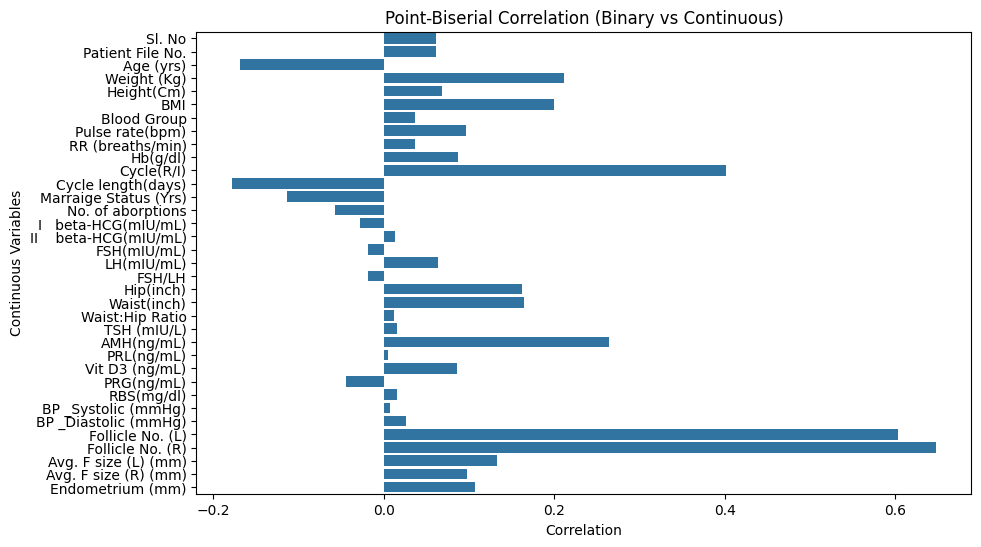

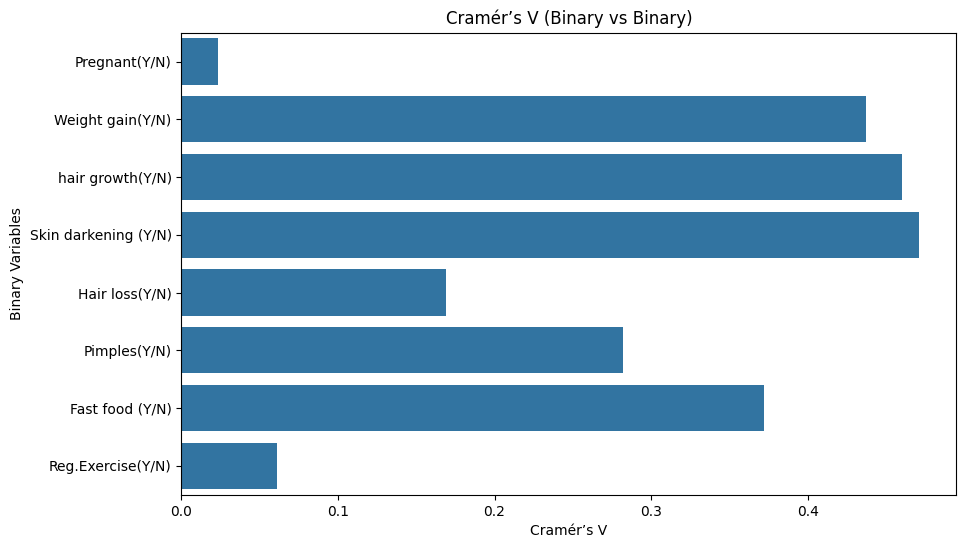

In [ ]:
# Correlations

df.columns = df.columns.str.strip()

# Identify columns
binary_cols = [col for col in df.columns if df[col].nunique() == 2]  # Binary (0/1) columns
continuous_cols = [col for col in df.columns if df[col].dtype != 'object' and df[col].nunique() > 2]  # Continuous variables

# Define target binary variable
binary_target = "PCOS (Y/N)"  # Change if necessary

# --- Point-Biserial Correlation: Binary vs. Continuous ---
pointbiserial_corr = []
for col in continuous_cols:
    corr, p_value = pointbiserialr(df[binary_target], df[col])
    pointbiserial_corr.append((col, corr, p_value))

# Plot Point-Biserial Correlations
cols, corrs, pvals = zip(*pointbiserial_corr)
plt.figure(figsize=(10, 6))
sns.barplot(x=corrs, y=cols)
plt.title("Point-Biserial Correlation (Binary vs Continuous)")
plt.xlabel("Correlation")
plt.ylabel("Continuous Variables")
plt.show()

# --- Cramér’s V: Binary vs. Binary ---
def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(table)
    return np.sqrt(chi2 / (df.shape[0] * (min(table.shape) - 1)))

cramers_v_results = []
binary_cols.remove(binary_target)  # Remove target from binary list
for col in binary_cols:
    v = cramers_v(df[binary_target], df[col])
    cramers_v_results.append((col, v))

# Plot Cramér’s V (Binary vs Binary)
cols, values = zip(*cramers_v_results)
plt.figure(figsize=(10, 6))
sns.barplot(x=values, y=cols)
plt.title("Cramér’s V (Binary vs Binary)")
plt.xlabel("Cramér’s V")
plt.ylabel("Binary Variables")
plt.show()


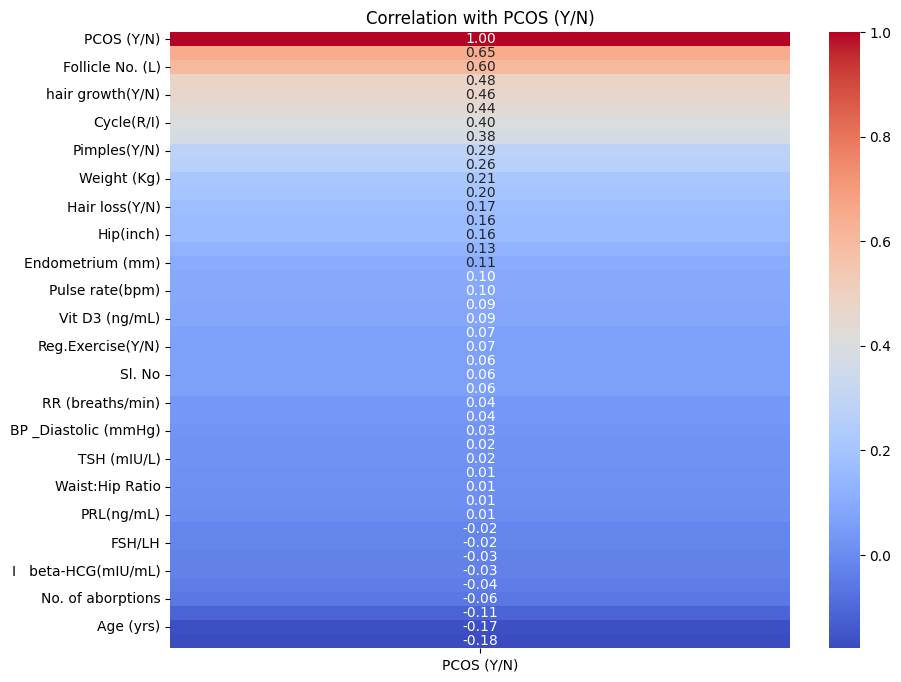

In [ ]:


corr_matrix = df.corr()

# Focus on PCOS correlation
pcos_corr = corr_matrix['PCOS (Y/N)'].sort_values(ascending=False)

# Plot heatmap for PCOS correlations
plt.figure(figsize=(10, 8))
sns.heatmap(pcos_corr.to_frame(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation with PCOS (Y/N)')
plt.show()


In [ ]:
# Filter out variables with high correlation (>0.5 or <-0.5) with 'PCOS (Y/N)'
high_corr_vars = pcos_corr[abs(pcos_corr) > 0.4].index.tolist()

# Exclude 'PCOS (Y/N)' itself, as it's used as hue
high_corr_vars.remove('PCOS (Y/N)')

# Check the selected variables
print(high_corr_vars)

['Follicle No. (R)', 'Follicle No. (L)', 'Skin darkening (Y/N)', 'hair growth(Y/N)', 'Weight gain(Y/N)', 'Cycle(R/I)']


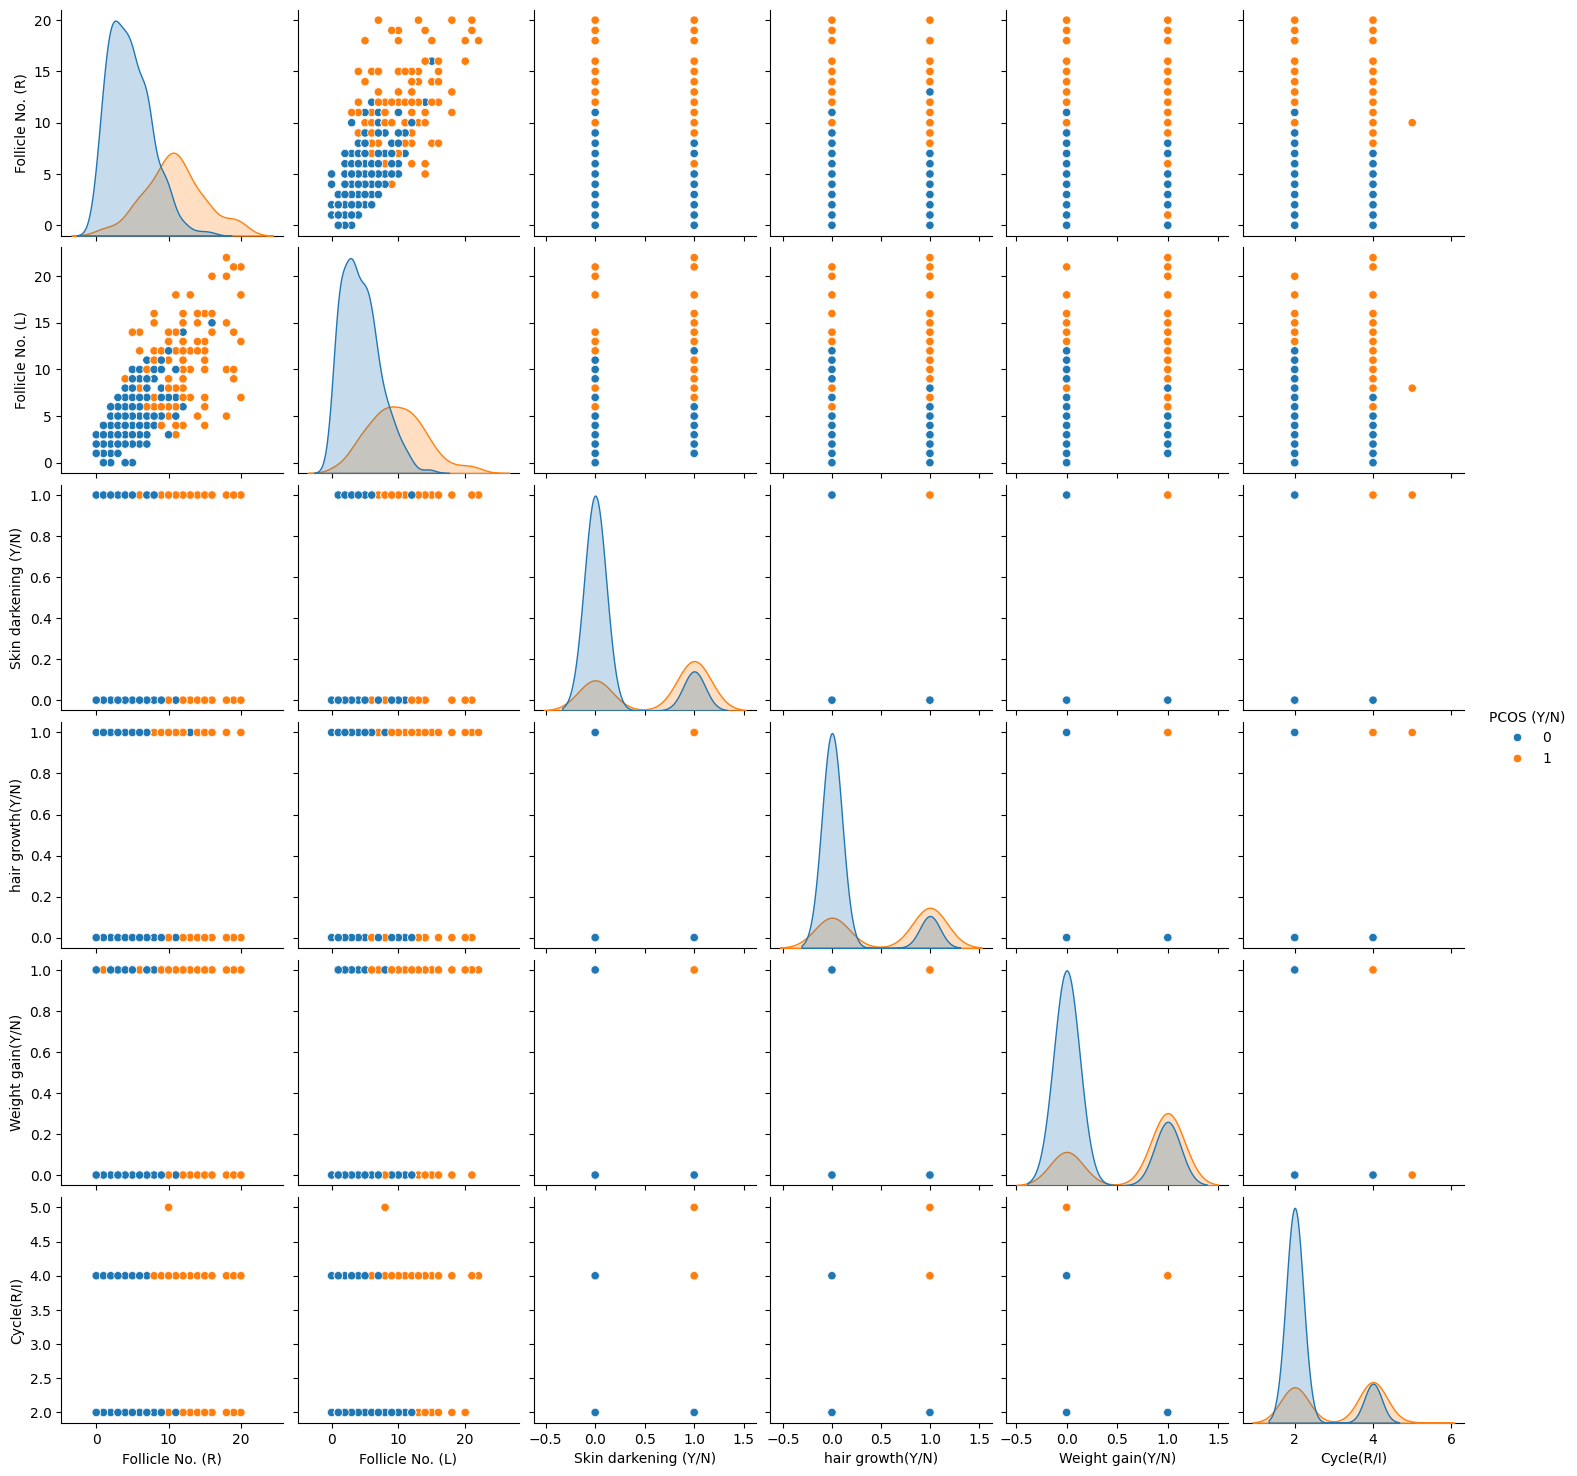

In [ ]:
sns.pairplot(df[high_corr_vars + ['PCOS (Y/N)']], hue='PCOS (Y/N)')
plt.show()



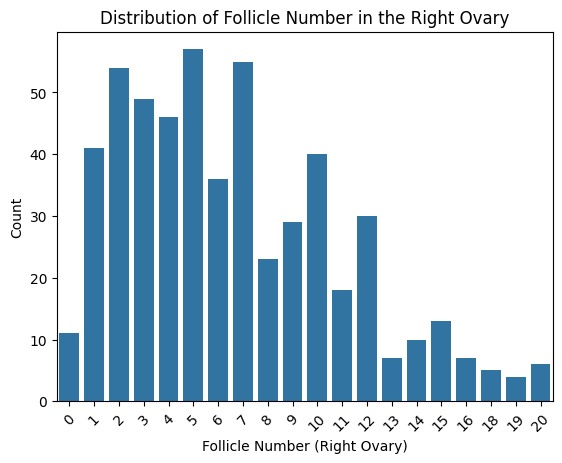

In [ ]:

# Plot the bar chart
sns.countplot(x=df['Follicle No. (R)'])

# Customize labels
plt.xlabel('Follicle Number (Right Ovary)')
plt.ylabel('Count')
plt.title('Distribution of Follicle Number in the Right Ovary')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.show()

## Plot the correlated variables vs PCOS

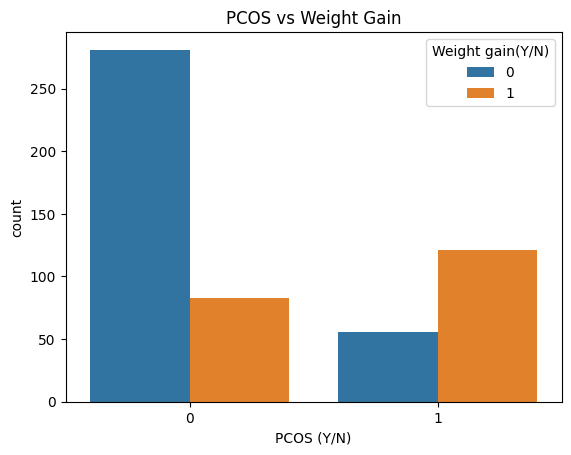

In [ ]:
sns.countplot(x='PCOS (Y/N)', hue='Weight gain(Y/N)', data=df)
plt.title('PCOS vs Weight Gain')
plt.show()



The data shows that individuals without PCOS (0) are more likely to not gain weight (0), while those with PCOS (1) exhibit a higher frequency of weight gain (1).

In [ ]:
df.groupby(['PCOS (Y/N)', 'Weight gain(Y/N)']).size().reset_index(name='count')


PCOS (Y/N)  Weight gain(Y/N)  count
0           0                 0    281
1           0                 1     83
2           1                 0     56
3           1                 1    121

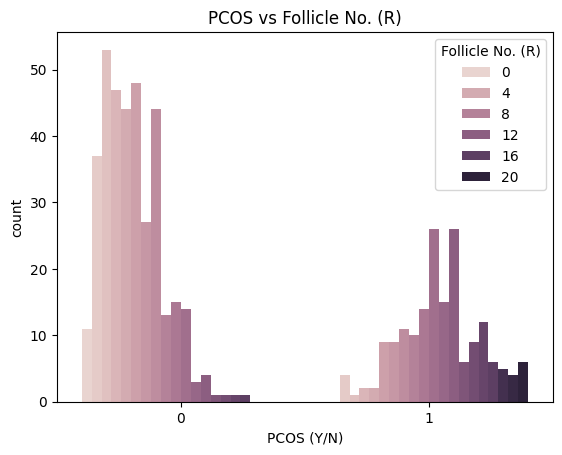

In [ ]:
sns.countplot(x='PCOS (Y/N)', hue='Follicle No. (R)', data=df)
plt.title('PCOS vs Follicle No. (R)')
plt.show()

The data shows how many people have different numbers of right follicles, with the PCOS-negative group (0) having fewer right follicles overall, while the PCOS-positive group (1) tends to have more right follicles, particularly in the higher ranges.

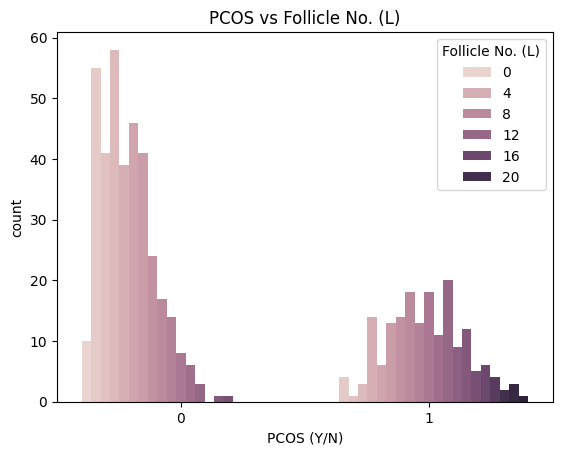

In [ ]:
sns.countplot(x='PCOS (Y/N)', hue='Follicle No. (L)', data=df)
plt.title('PCOS vs Follicle No. (L)')
plt.show()

The data shows that individuals without PCOS (0) generally have fewer follicles on the left ovary, with most having between 1 and 7 follicles. In contrast, those with PCOS (1) tend to have a higher number of follicles, with a noticeable increase in counts beyond 7, indicating a potential link between higher follicle numbers and PCOS.

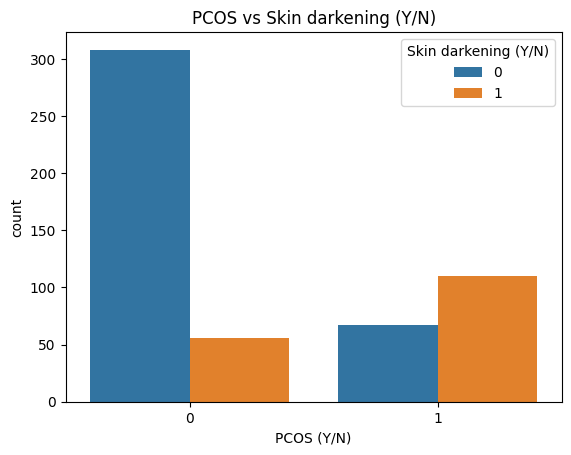

In [ ]:
sns.countplot(x='PCOS (Y/N)', hue='Skin darkening (Y/N)', data=df)
plt.title('PCOS vs Skin darkening (Y/N)')
plt.show()

The data suggests that skin darkening is more common in individuals with PCOS compared to those without PCOS. This indicates a possible association between PCOS and skin darkening.

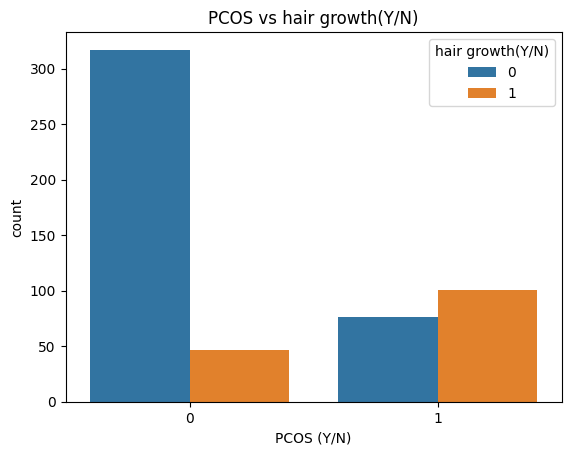

In [ ]:
sns.countplot(x='PCOS (Y/N)', hue='hair growth(Y/N)', data=df)
plt.title('PCOS vs hair growth(Y/N)')
plt.show()

The data suggests that excessive hair growth (hirsutism) is more common in individuals with PCOS (101 out of 177) compared to those without PCOS (47 out of 364). This indicates a potential link between PCOS and increased hair growth.

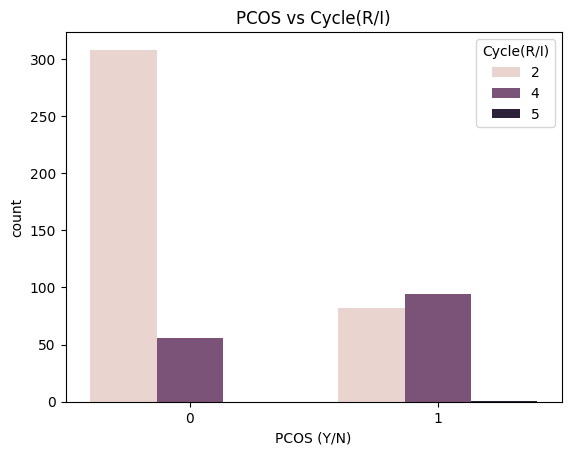

In [ ]:
sns.countplot(x='PCOS (Y/N)', hue='Cycle(R/I)', data=df)
plt.title('PCOS vs Cycle(R/I)')
plt.show()

The data shows that individuals without PCOS (0) predominantly have a regular cycle (R), while those with PCOS (1) show a mix of both regular (R) and irregular (I) cycles, with a higher frequency of irregular cycles.

In [ ]:
df.groupby(['PCOS (Y/N)', 'Cycle(R/I)']).size().reset_index(name='count')


PCOS (Y/N)  Cycle(R/I)  count
0           0           2    308
1           0           4     56
2           1           2     82
3           1           4     94
4           1           5      1

In [ ]:
#pip install statsmodels


Now lets try to find the multicolinearity for regression models using variance inflation factor. this will help us eliminate highly correlated columns which make it difficult for models to learn the patterns.

In [ ]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Select only numerical columns (excluding categorical ones)
num_vars = [col for col in df.columns if df[col].dtype != 'object' and df[col].nunique() > 2]  # Continuous variables
num_vars_df = df[num_vars]

# Add a constant column to account for intercept term in VIF calculation
num_vars_with_const = add_constant(num_vars_df)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Feature"] = num_vars_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(num_vars_with_const.values, i) for i in range(num_vars_with_const.shape[1])]

# Display variables with high multicollinearity
print(vif_data.sort_values(by="VIF", ascending=False))


                   Feature           VIF
1                   Sl. No           inf
2         Patient File No.           inf
0                    const  7.085666e+04
21             Waist(inch)  4.508207e+02
20               Hip(inch)  4.478960e+02
4              Weight (Kg)  2.029146e+02
6                      BMI  1.678670e+02
22         Waist:Hip Ratio  1.117280e+02
5               Height(Cm)  3.813374e+01
31        Follicle No. (L)  3.323550e+00
32        Follicle No. (R)  3.181135e+00
3                Age (yrs)  2.051813e+00
13   Marraige Status (Yrs)  1.982076e+00
33    Avg. F size (L) (mm)  1.606567e+00
34    Avg. F size (R) (mm)  1.517504e+00
15    I   beta-HCG(mIU/mL)  1.470341e+00
8          Pulse rate(bpm)  1.462619e+00
16  II    beta-HCG(mIU/mL)  1.447346e+00
9         RR (breaths/min)  1.412537e+00
11              Cycle(R/I)  1.302471e+00
24              AMH(ng/mL)  1.210653e+00
14       No. of aborptions  1.168080e+00
12      Cycle length(days)  1.129706e+00
30    BP _Diasto

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



"Waist:Hip Ratio" and "Waist(inch)" are high correlated, since waist ratio is calculated from waist we remove the waist.


In [ ]:
df_1=df.copy()
df_1.drop(['Waist(inch)'],axis=1,inplace=True)

BMI is derived from Weight & Height. we drop Weight (Kg) since BMI already captures weight.

In [ ]:
df_1.drop(['Weight (Kg)'],axis=1,inplace=True)

BP Systolic (Pressure when the heart beats) and BP Diastolic(Pressure when the heart rests) are correlated, but since both provide important clinical information and together, they help in assessing overall cardiovascular health and are crucial in diagnosing conditions like hypertension, we keep them.

Follicle Number (L) and Follicle Number (R) are high correlated but thay are important clinical indicators, especially in PCOS (Polycystic Ovary Syndrome) cases, so we decide to keep them.

But we can average them so that they are not lost during feature selection. Hence, doing so below

In [ ]:
# Create a feature 'Avg_Follicle No' using 'Follicle No. (L)' and 'Follicle No. (R)' in df and drop the laster 2 features
df_1['Avg_Follicle No'] = (df['Follicle No. (L)'] + df['Follicle No. (R)']) / 2
df_1.drop(['Follicle No. (L)', 'Follicle No. (R)'], axis=1, inplace=True)

#Create a feature 'Avg_F size (mm)' using 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)' in df_1 and drop the later 2 features
df_1['Avg_F size (mm)'] = (df['Avg. F size (L) (mm)'] + df['Avg. F size (R) (mm)']) / 2
df_1.drop(['Avg. F size (L) (mm)', 'Avg. F size (R) (mm)'], axis=1, inplace=True)

In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3   Age (yrs)               541 non-null    int64  
 4   Height(Cm)              541 non-null    float64
 5   BMI                     541 non-null    float64
 6   Blood Group             541 non-null    int64  
 7   Pulse rate(bpm)         541 non-null    float64
 8   RR (breaths/min)        541 non-null    int64  
 9   Hb(g/dl)                541 non-null    float64
 10  Cycle(R/I)              541 non-null    int64  
 11  Cycle length(days)      541 non-null    int64  
 12  Marraige Status (Yrs)   541 non-null    float64
 13  Pregnant(Y/N)           541 non-null    int64  
 14  No. of aborptions       541 non-null    in

In [ ]:
df_1['PCOS (Y/N)'].value_counts()

PCOS (Y/N)
0    364
1    177
Name: count, dtype: int64

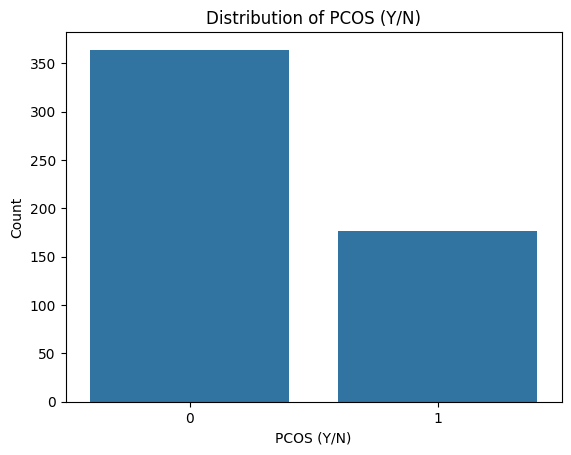

In [ ]:

# Plot the distribution of the target variable (PCOS)
sns.countplot(x='PCOS (Y/N)', data=df_1)
plt.title('Distribution of PCOS (Y/N)')
plt.xlabel('PCOS (Y/N)')
plt.ylabel('Count')
plt.show()


##Plot Discrete and Continuous Variables and outliers

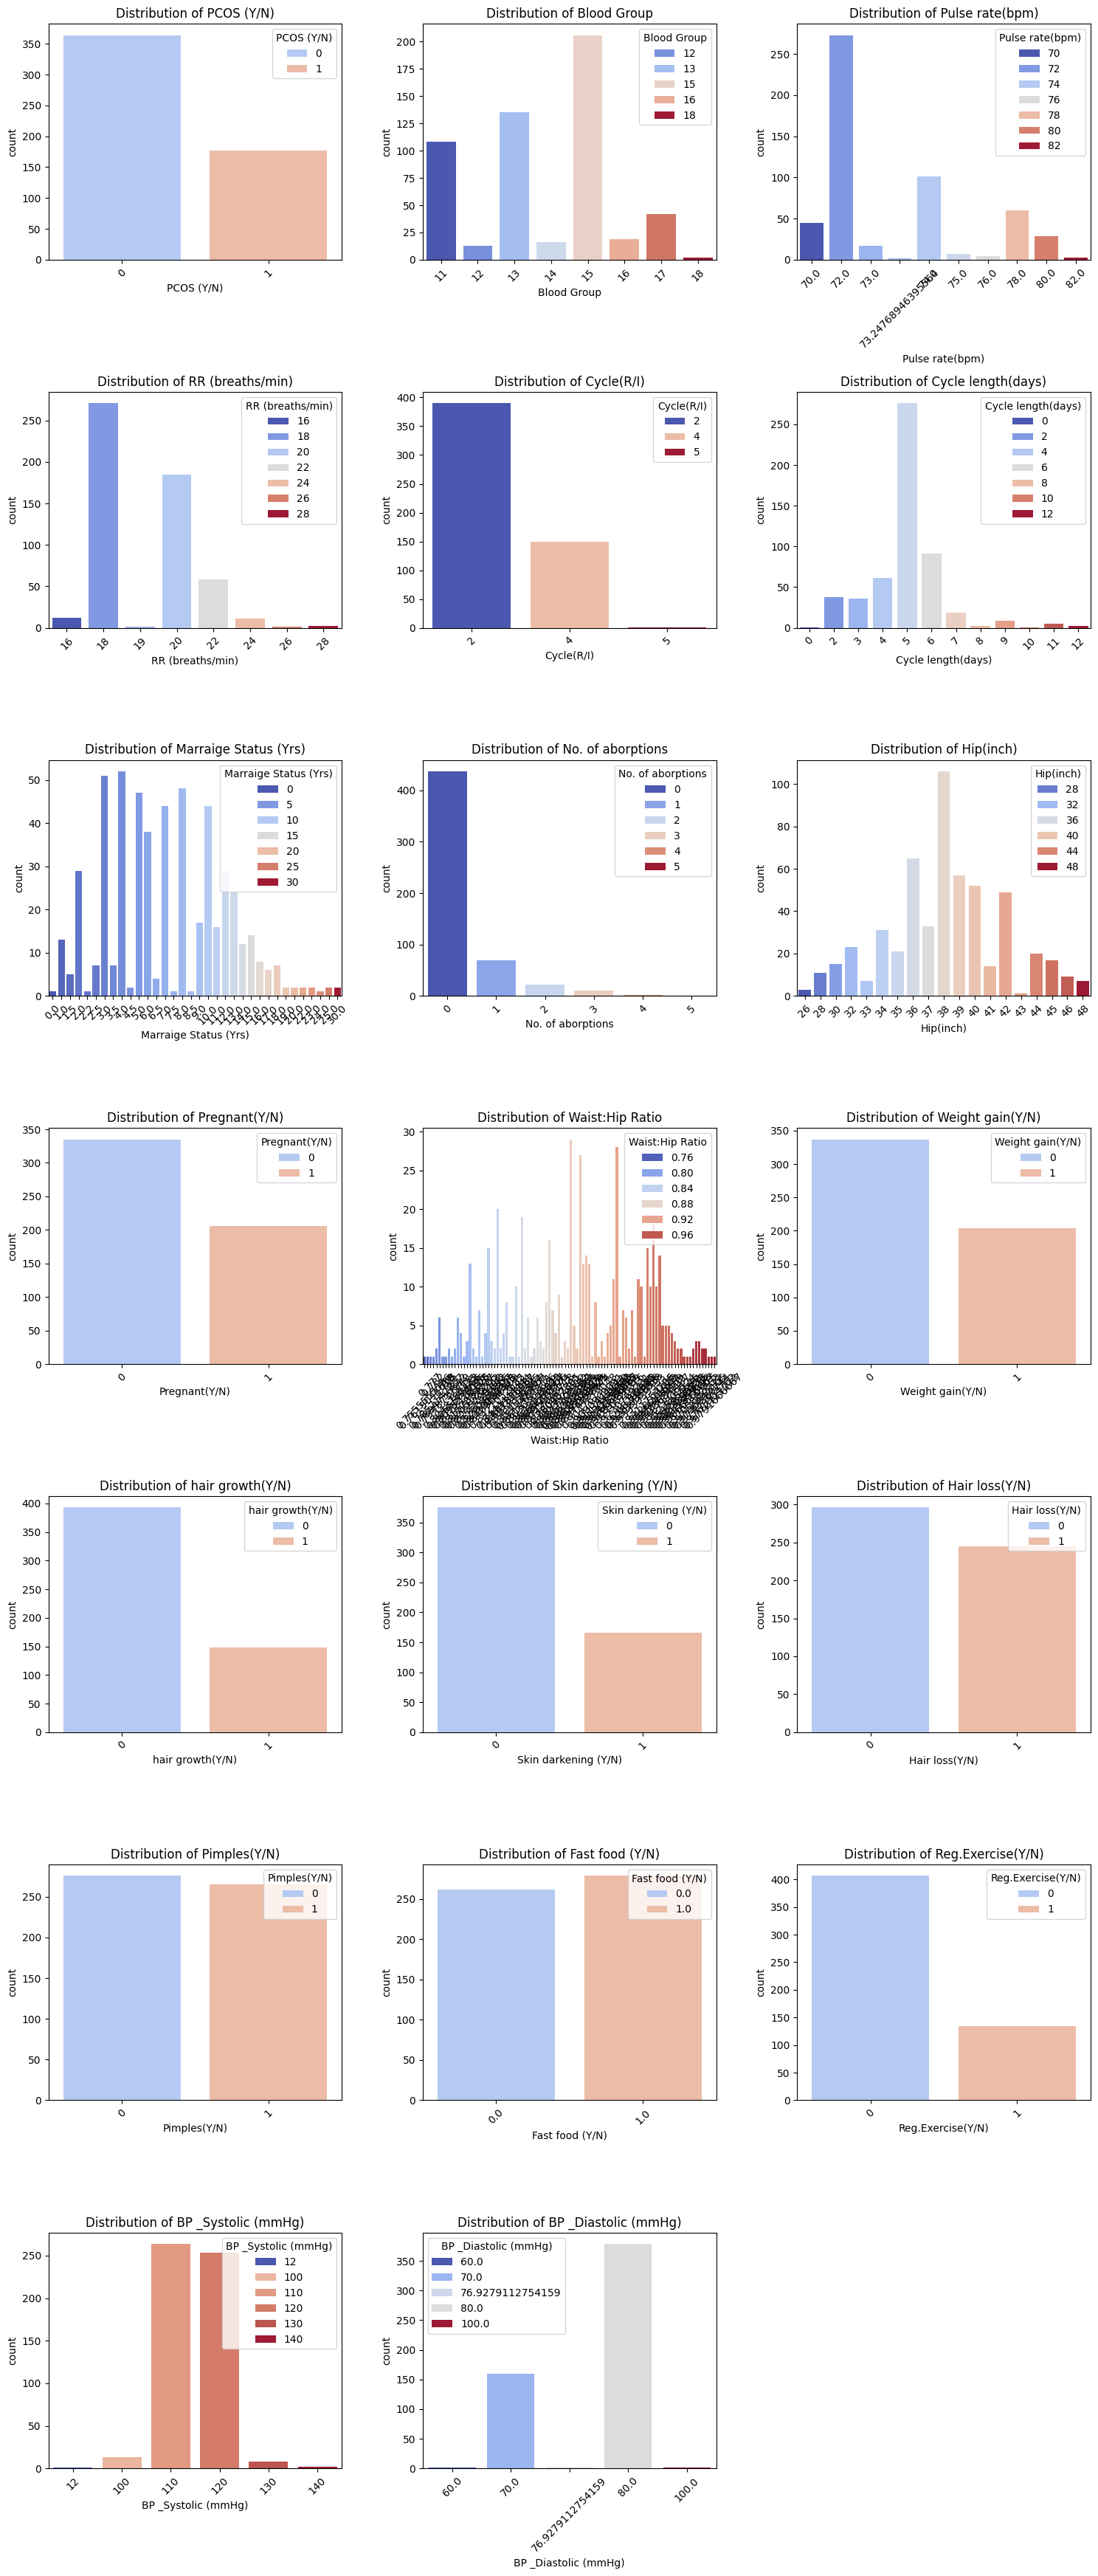

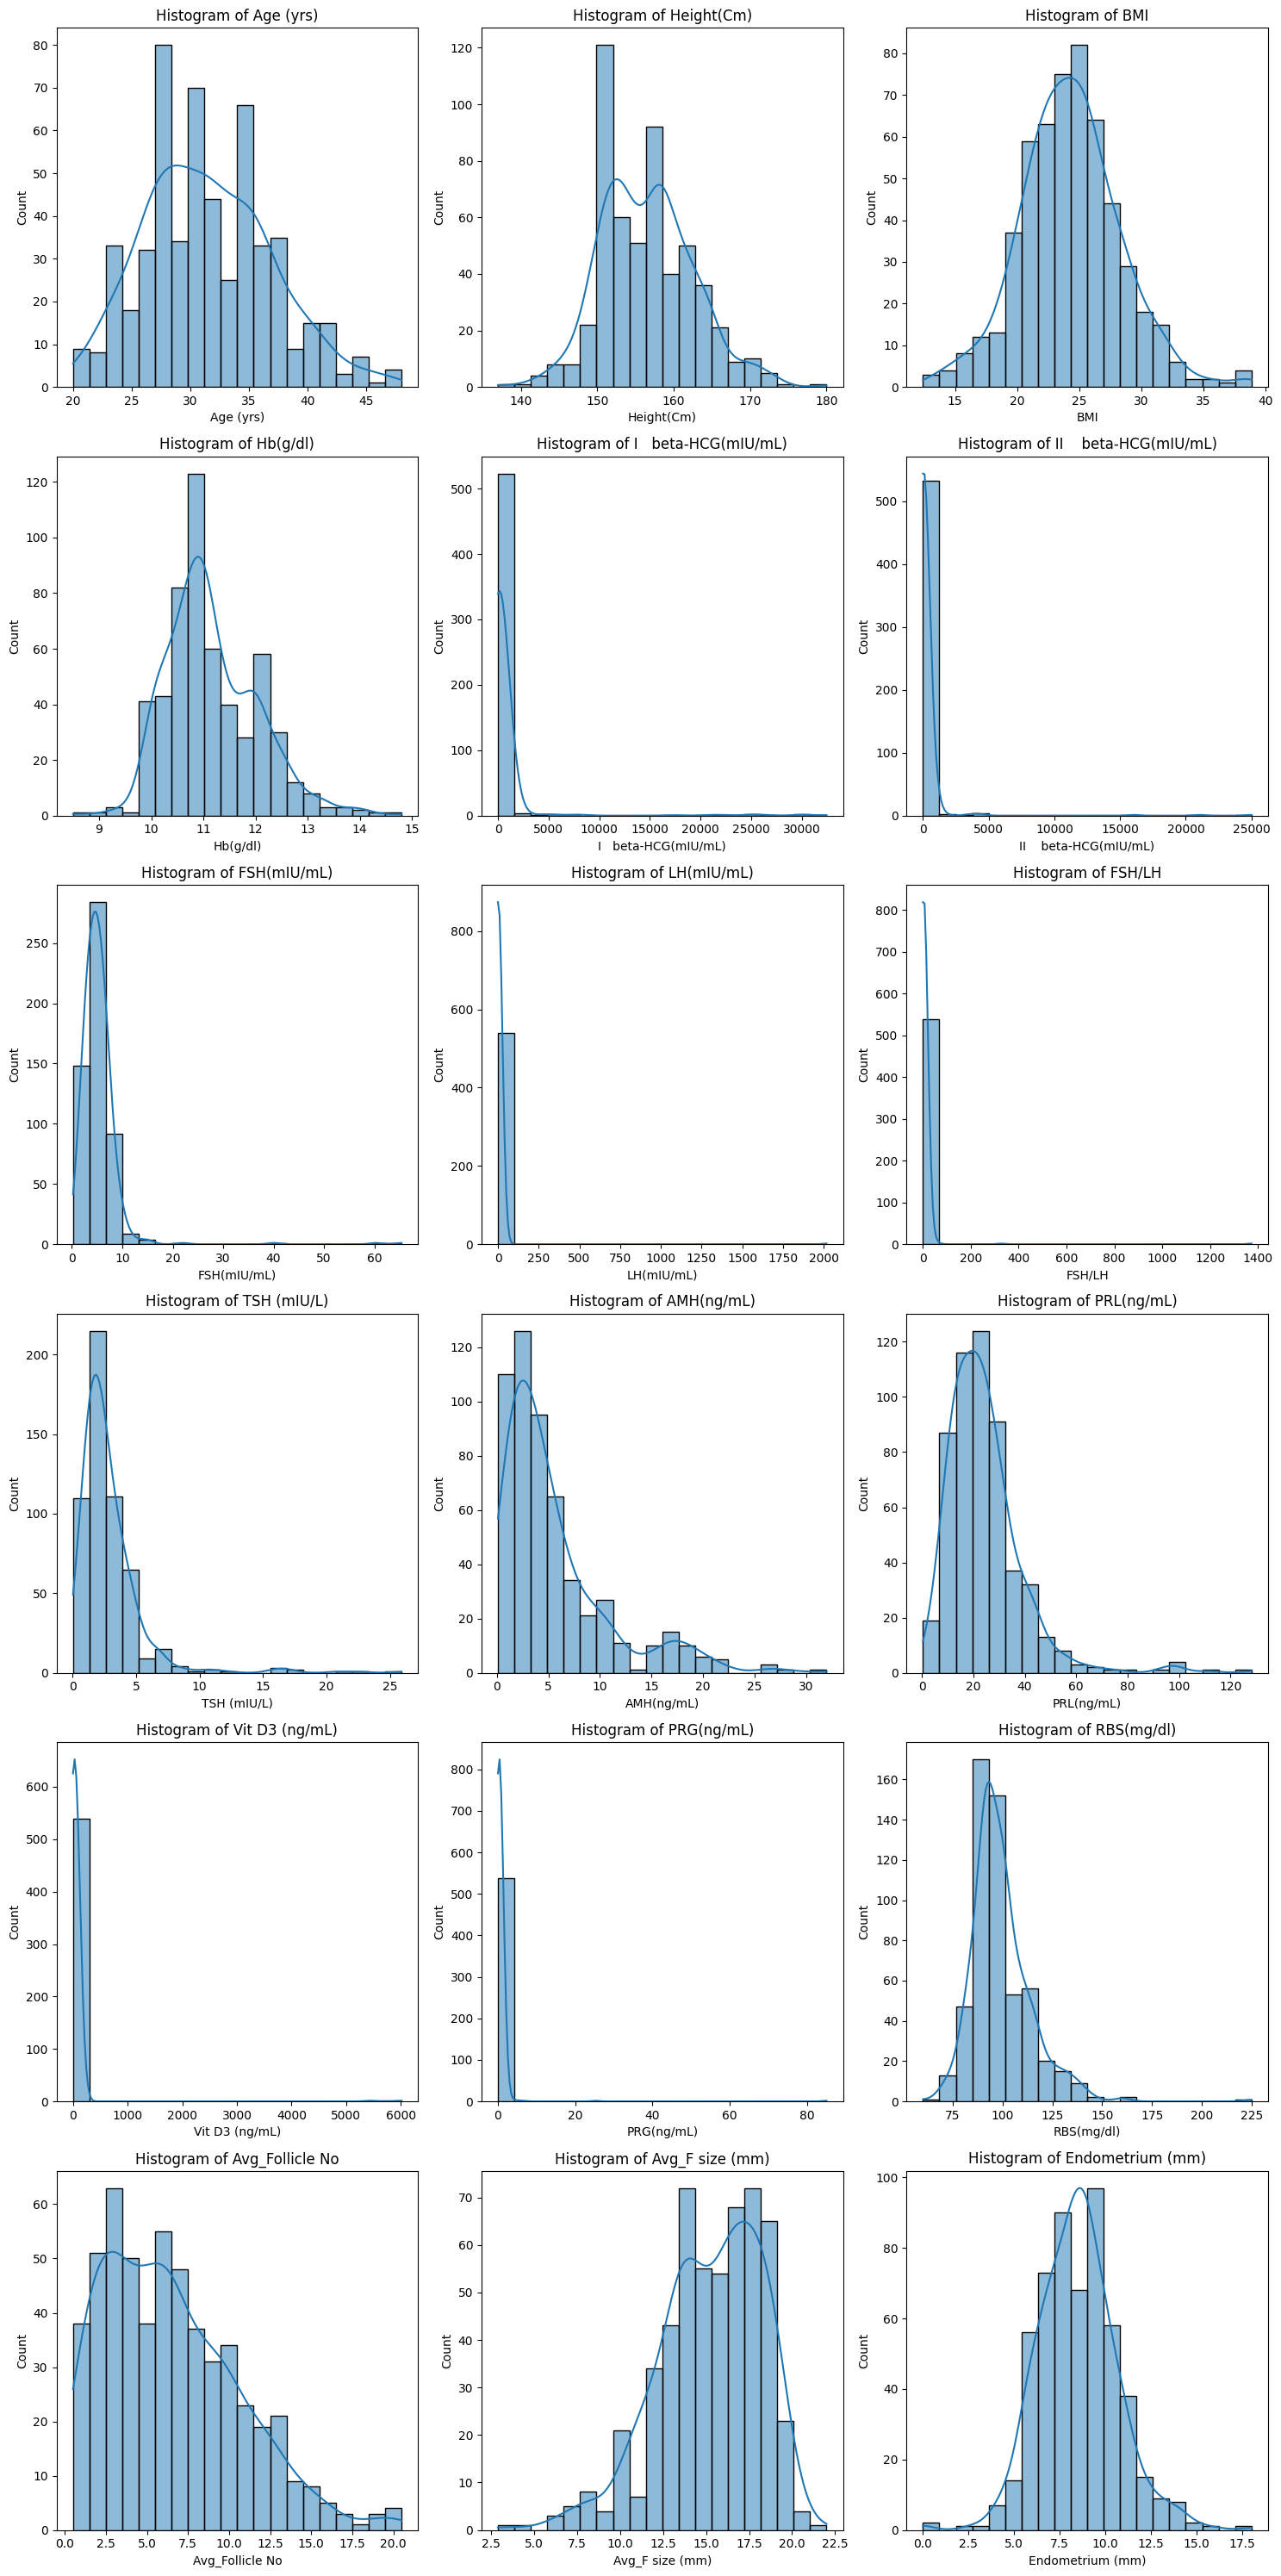

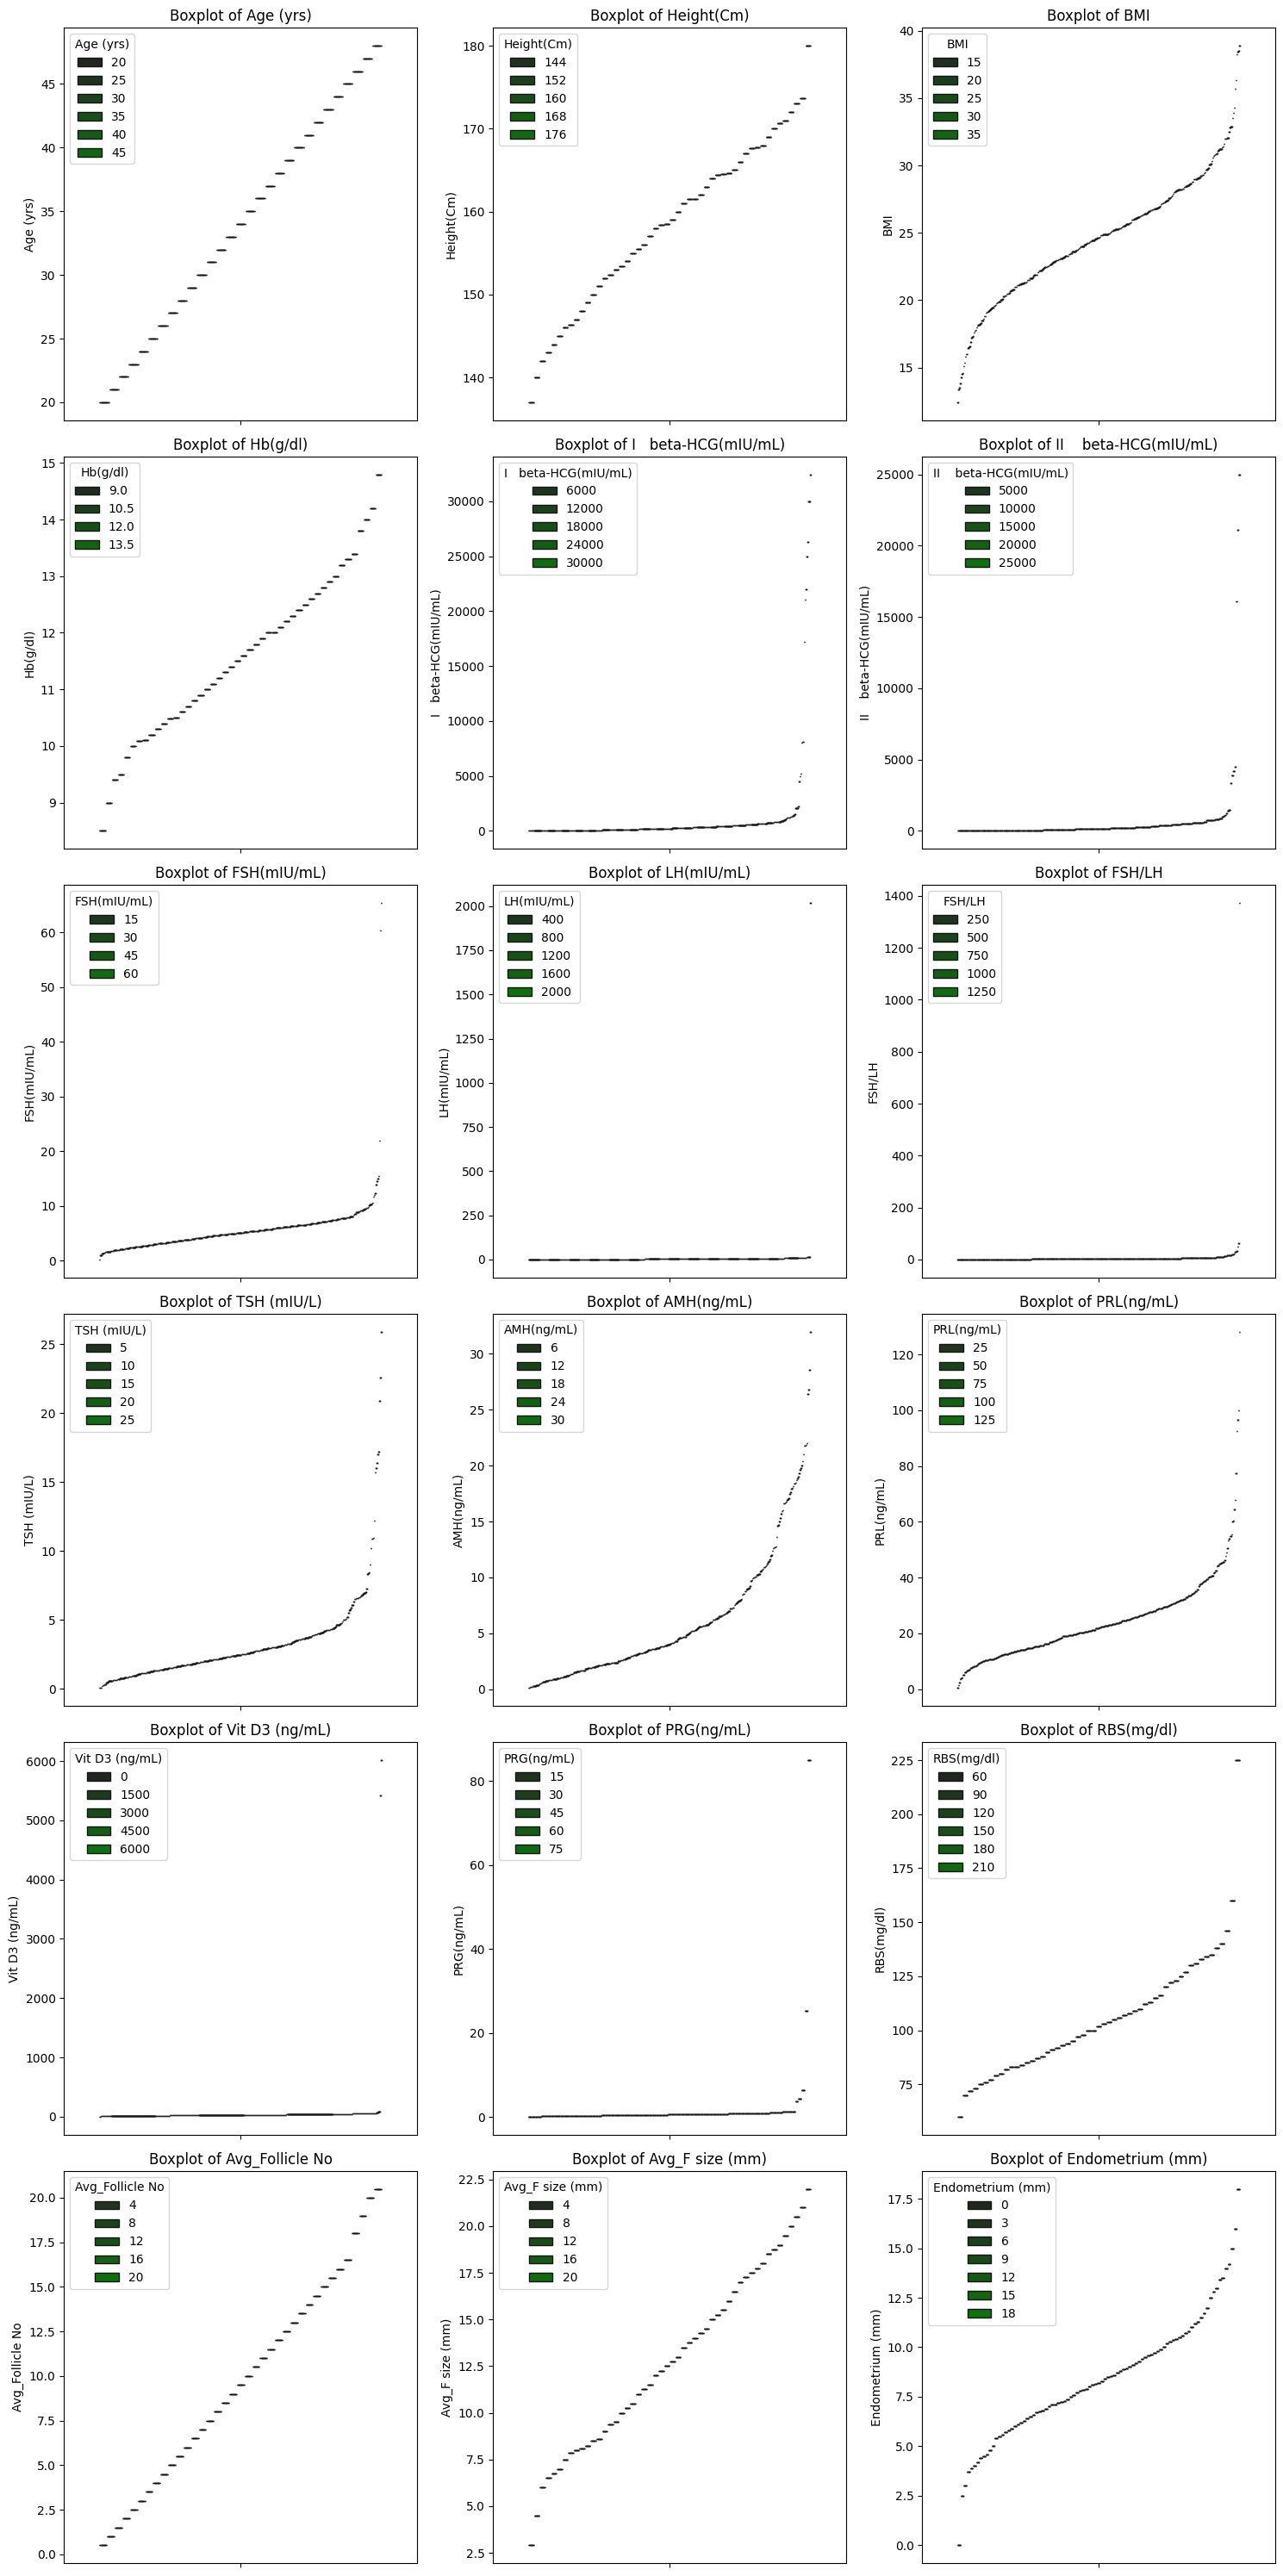

In [ ]:

import math

# Identify Discrete and Continuous Variables
discrete_vars = ['PCOS (Y/N)', 'Blood Group', 'Pulse rate(bpm)', 'RR (breaths/min)', 'Cycle(R/I)',
                 'Cycle length(days)', 'Marraige Status (Yrs)', 'No. of aborptions', 'Hip(inch)',
                 'Pregnant(Y/N)', 'Waist:Hip Ratio', 'Weight gain(Y/N)', 'hair growth(Y/N)',
                 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)',
                 'BP _Systolic (mmHg)', 'BP _Diastolic (mmHg)']

continuous_vars = ['Age (yrs)', 'Height(Cm)', 'BMI', 'Hb(g/dl)', 'I   beta-HCG(mIU/mL)',
                   'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH', 'TSH (mIU/L)', 'AMH(ng/mL)',
                   'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'PRG(ng/mL)', 'RBS(mg/dl)', 'Avg_Follicle No',
                   'Avg_F size (mm)', 'Endometrium (mm)']

# Adjust layout dynamically
cols = 3  # Set fixed number of columns
rows_discrete = math.ceil(len(discrete_vars) / cols)
rows_continuous = math.ceil(len(continuous_vars) / cols)

df_1.columns = df_1.columns.str.strip()


# Plot Discrete Variables (Bar Plots)
plt.figure(figsize=(15, 5 * rows_discrete))  # Adjust figure size
for i, col in enumerate(discrete_vars):
    plt.subplot(rows_discrete, cols, i + 1)
    sns.countplot(x=df_1[col], palette='coolwarm', hue=df_1[col])
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)  # Rotate labels for better visibility

plt.tight_layout()
plt.show()

# Plot Continuous Variables (Histogram)
plt.figure(figsize=(15, 5 * rows_continuous))  # Adjust figure size
for i, col in enumerate(continuous_vars):
    plt.subplot(rows_continuous, cols, i + 1)
    sns.histplot(df_1[col], kde=True, bins=20)
    plt.title(f"Histogram of {col}")

plt.tight_layout()
plt.show()

# Box Plot for Continuous Variables (Outlier Detection)
plt.figure(figsize=(15, 5 * rows_continuous))  # Adjust figure size
for i, col in enumerate(continuous_vars):
    plt.subplot(rows_continuous, cols, i + 1)
    sns.boxplot(y=df_1[col], palette='dark:green', hue=df_1[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


## Boxplots

In [ ]:


def plot_and_save_boxplots(df, features, save_path="boxplots", cols=4):
    """
    Creates and saves boxplots for the given features in a dataset, displaying them in a grid layout.

    Parameters:
    df (pd.DataFrame): The dataset containing the features.
    features (list): List of feature names to visualize.
    save_path (str): Directory to save the boxplot images.
    cols (int): Number of boxplots per row.
    """
    import os
    os.makedirs(save_path, exist_ok=True)  # Create directory if it doesn't exist

    num_features = len(features)
    rows = (num_features // cols) + (num_features % cols > 0)  # Calculate rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        if feature in df_1.columns:
            sns.boxplot(y=df_1[feature], ax=axes[i])
            axes[i].set_title(f'Boxplot of {feature}')
            axes[i].set_ylabel(feature)
            axes[i].grid(True)
        else:
            axes[i].set_visible(False)  # Hide unused subplots

    # Remove any extra empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    file_path = os.path.join(save_path, "boxplots_grid.png")
    plt.savefig(file_path, format='png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved boxplots grid at {file_path}")

features_to_plot = ['Pulse rate(bpm)', 'RR (breaths/min)', 'Cycle(R/I)',
                 'Cycle length(days)', 'Marraige Status (Yrs)', 'No. of aborptions', 'Hip(inch)', 'Waist:Hip Ratio',
                 'BP _Systolic (mmHg)', 'BP _Diastolic (mmHg)', 'Age (yrs)', 'Height(Cm)', 'BMI', 'Hb(g/dl)', 'TSH (mIU/L)', 'AMH(ng/mL)',
                   'PRL(ng/mL)', 'RBS(mg/dl)', 'Avg_Follicle No',
                   'Avg_F size (mm)', 'Endometrium (mm)']
plot_and_save_boxplots(df_1, features_to_plot)


Saved boxplots grid at boxplots/boxplots_grid.png


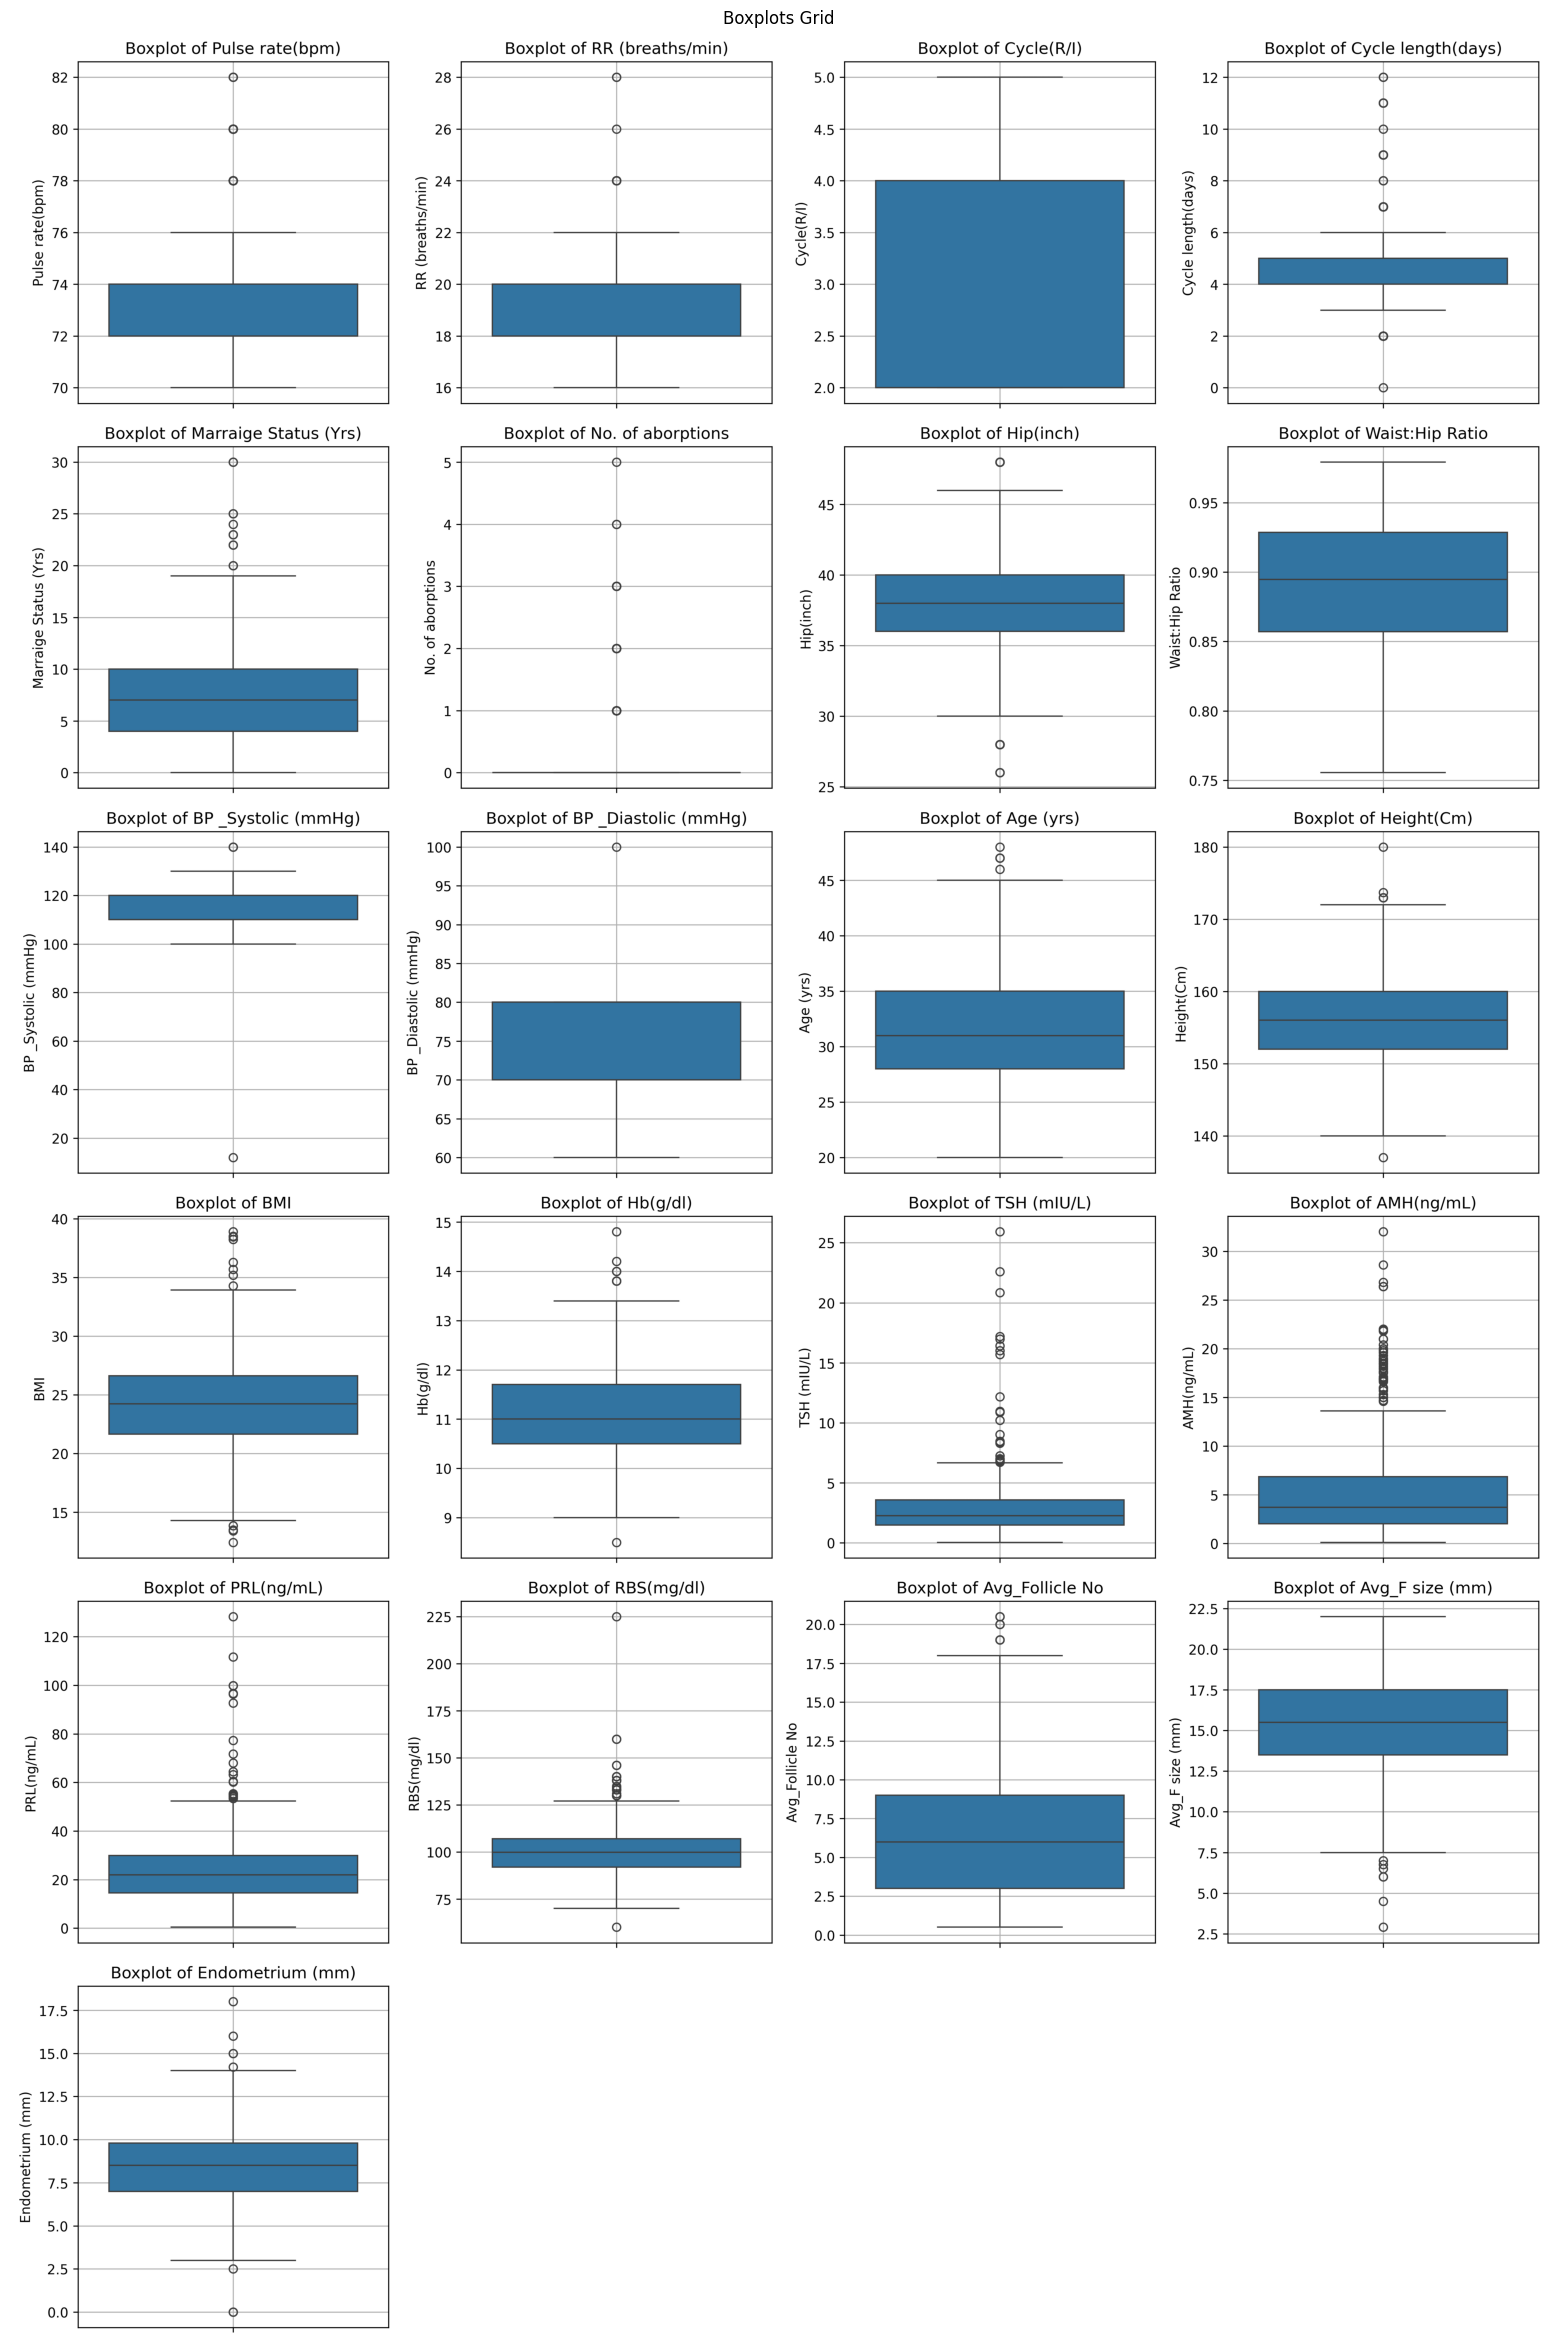

In [ ]:

# Define the image path
image_path = "boxplots/boxplots_grid.png"

# Load and display the image with larger dimensions
plt.figure(figsize=(30, 30))  # Adjust the width and height as needed
img = plt.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title("Boxplots Grid")
plt.show()


We will deal with the outlier later before training the model.

##Log_transformation

In [ ]:
df_2 = df_1.copy()
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3   Age (yrs)               541 non-null    int64  
 4   Height(Cm)              541 non-null    float64
 5   BMI                     541 non-null    float64
 6   Blood Group             541 non-null    int64  
 7   Pulse rate(bpm)         541 non-null    float64
 8   RR (breaths/min)        541 non-null    int64  
 9   Hb(g/dl)                541 non-null    float64
 10  Cycle(R/I)              541 non-null    int64  
 11  Cycle length(days)      541 non-null    int64  
 12  Marraige Status (Yrs)   541 non-null    float64
 13  Pregnant(Y/N)           541 non-null    int64  
 14  No. of aborptions       541 non-null    in

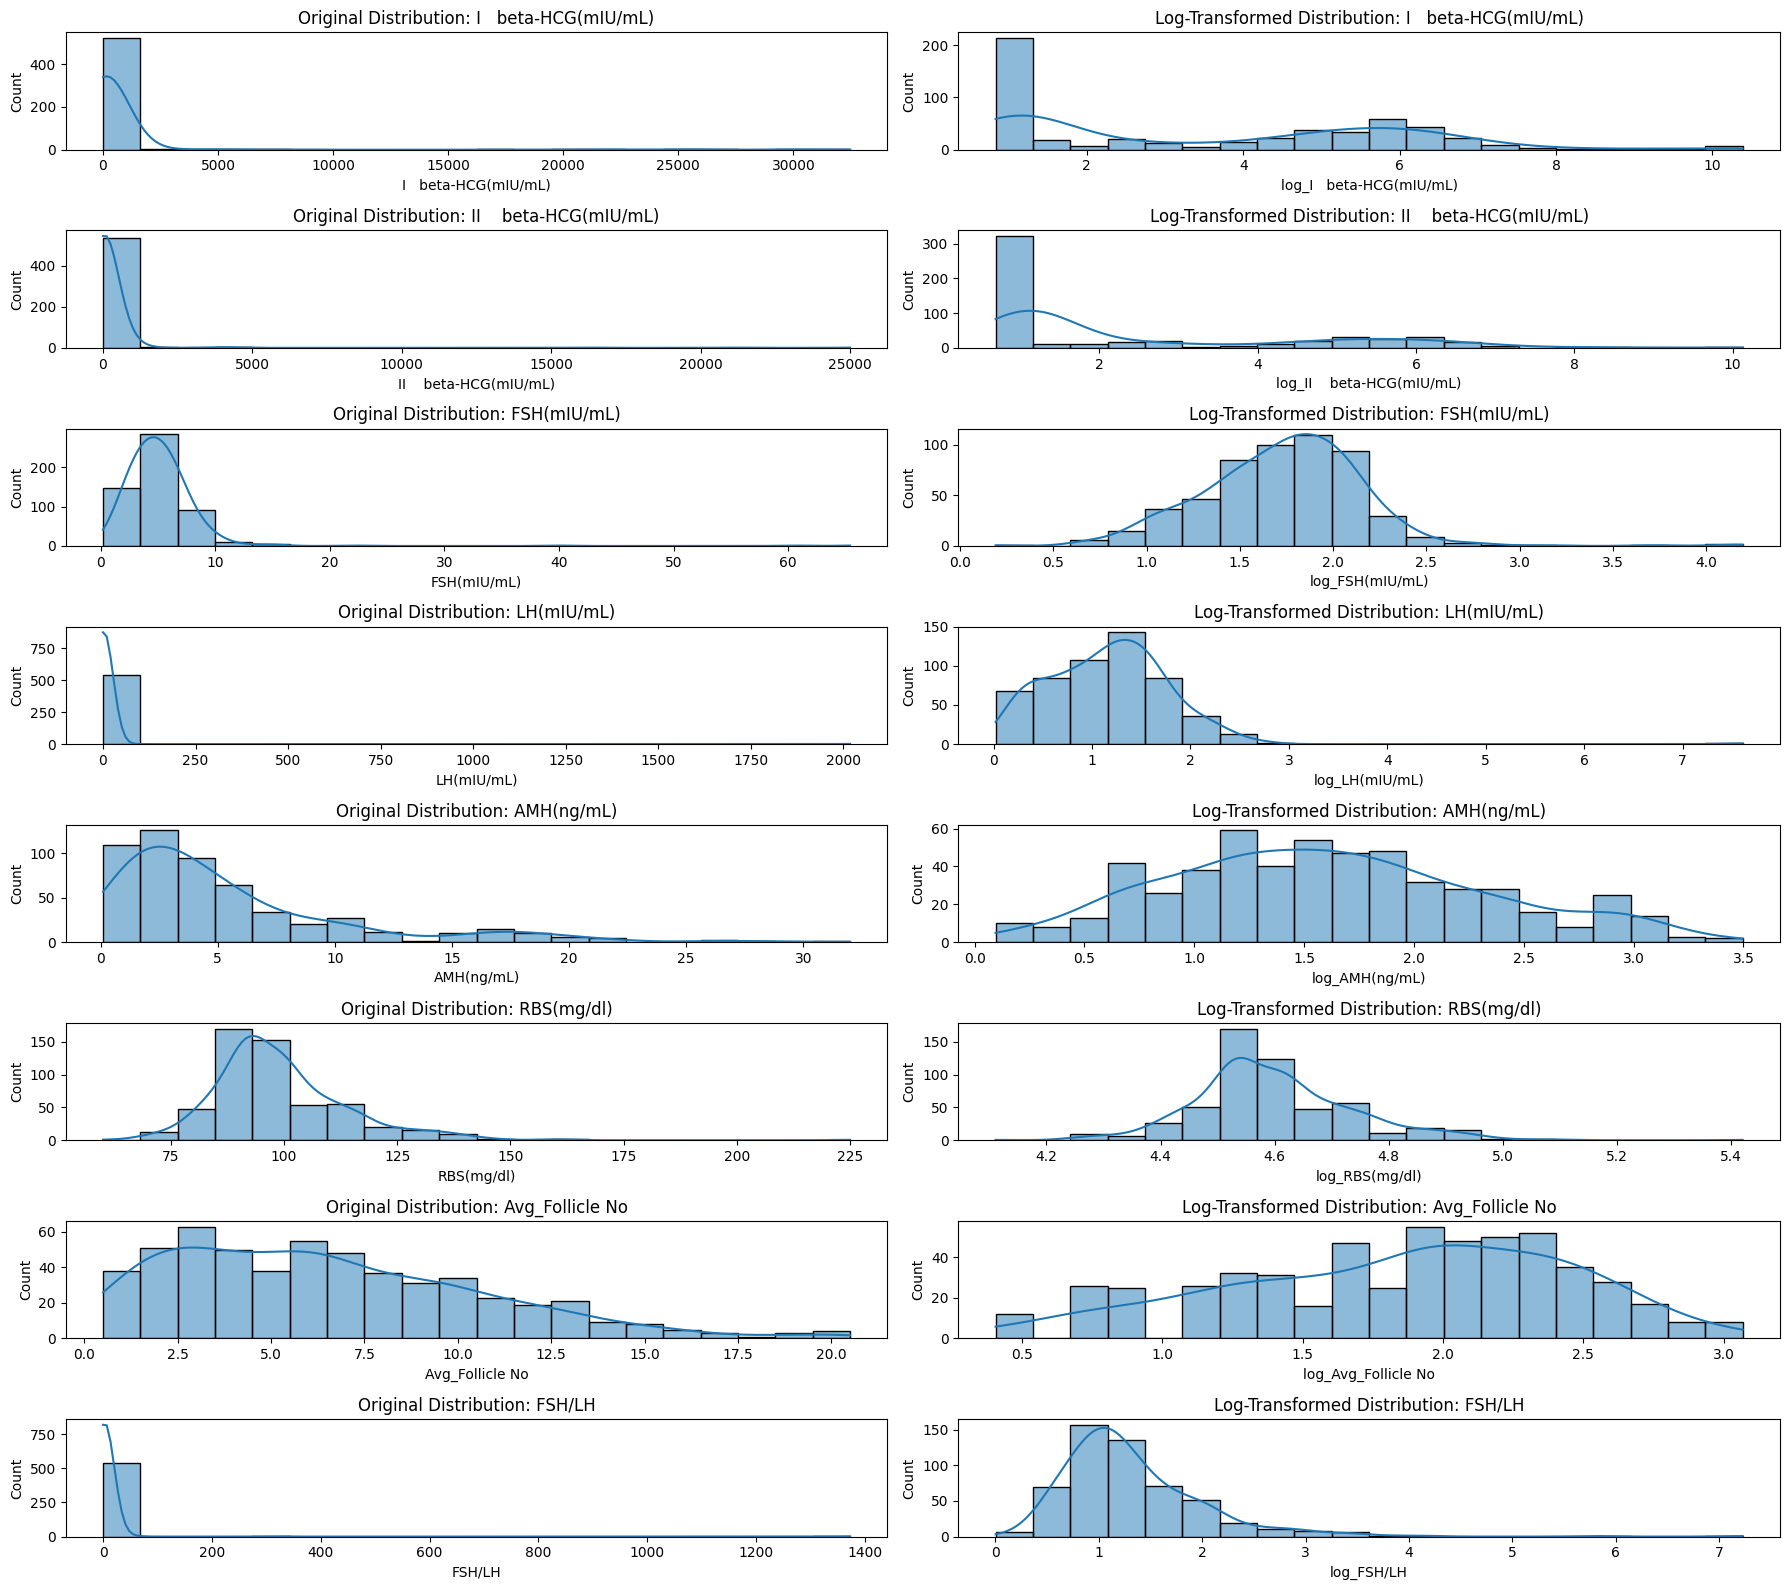

In [ ]:


# List of columns for log transformation
columns_to_transform = ['I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)', 'LH(mIU/mL)', 'AMH(ng/mL)',
                        'RBS(mg/dl)', 'Avg_Follicle No', 'FSH/LH']

# Apply log transformation
for col in columns_to_transform:
    df_2[f'log_{col}'] = np.log(df_1[col] + 1)  # Log transformation with +1 to avoid log(0)

# Plot original vs log-transformed distributions
plt.figure(figsize=(18, 16))

# Iterate over columns for original and transformed plots
for i, col in enumerate(columns_to_transform):
    plt.subplot(len(columns_to_transform), 2, 2*i + 1)
    sns.histplot(df_2[col], kde=True, bins=20)
    plt.title(f"Original Distribution: {col}")

    plt.subplot(len(columns_to_transform), 2, 2*i + 2)
    sns.histplot(df_2[f'log_{col}'], kde=True, bins=20)
    plt.title(f"Log-Transformed Distribution: {col}")

plt.tight_layout()
plt.show()

df_2 = df_2.drop(columns_to_transform, axis=1)

In [ ]:
df_2.columns

Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', 'Age (yrs)', 'Height(Cm)',
       'BMI', 'Blood Group', 'Pulse rate(bpm)', 'RR (breaths/min)', 'Hb(g/dl)',
       'Cycle(R/I)', 'Cycle length(days)', 'Marraige Status (Yrs)',
       'Pregnant(Y/N)', 'No. of aborptions', 'Hip(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'PRG(ng/mL)',
       'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
       'Hair loss(Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)',
       'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)', 'BP _Diastolic (mmHg)',
       'Endometrium (mm)', 'Avg_F size (mm)', 'log_I   beta-HCG(mIU/mL)',
       'log_II    beta-HCG(mIU/mL)', 'log_FSH(mIU/mL)', 'log_LH(mIU/mL)',
       'log_AMH(ng/mL)', 'log_RBS(mg/dl)', 'log_Avg_Follicle No',
       'log_FSH/LH'],
      dtype='object')

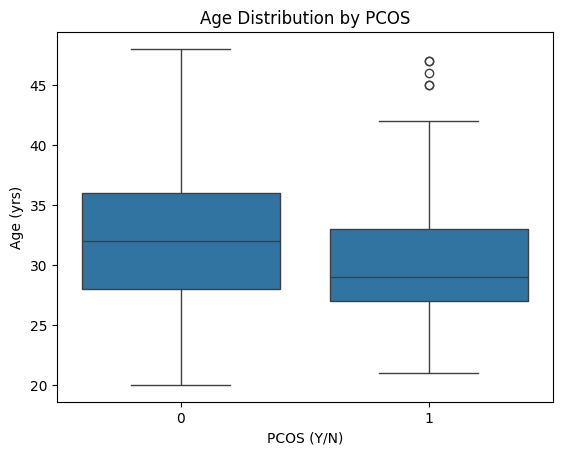

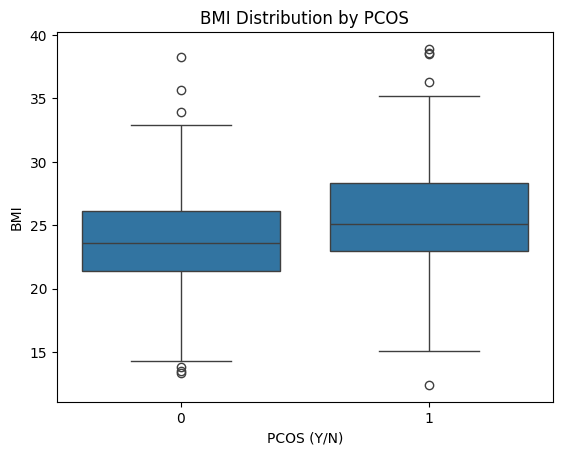

In [ ]:
# Visualizing continuous variables (e.g., Age, BMI) for PCOS = 1 and PCOS = 0
sns.boxplot(x='PCOS (Y/N)', y='Age (yrs)', data=df_2)
plt.title('Age Distribution by PCOS')
plt.show()

sns.boxplot(x='PCOS (Y/N)', y='BMI', data=df_2)
plt.title('BMI Distribution by PCOS')
plt.show()



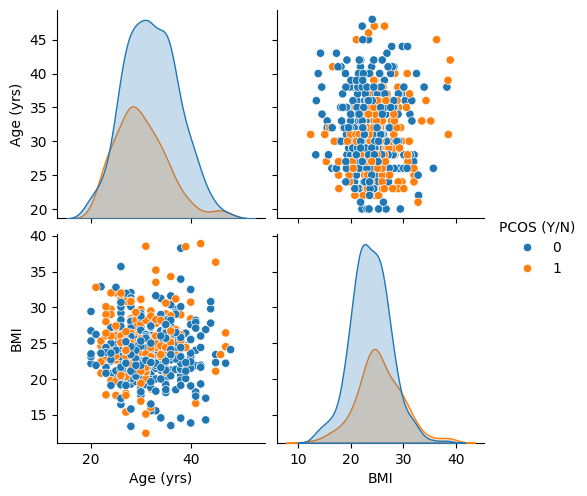

In [ ]:
# Select a few continuous variables
continuous_vars = ['Age (yrs)', 'BMI']

# Pairplot to visualize relationships between continuous variables, grouped by PCOS
sns.pairplot(df_2[continuous_vars + ['PCOS (Y/N)']], hue='PCOS (Y/N)')
plt.show()


In [ ]:
df_2['PCOS (Y/N)'].value_counts()


PCOS (Y/N)
0    364
1    177
Name: count, dtype: int64

# Feature Selection


In [ ]:
# Creating another df incase of future problems
df_3=df_2.copy()

### Correlations check using pointbiserial

In [ ]:


X = df_3.drop(columns=['PCOS (Y/N)', 'Sl No', 'Patient File No'], errors='ignore')
y = df_3['PCOS (Y/N)']

correlation_coefficients = []
p_values = []
feature_names = X.columns

for feature in feature_names:
    corr, p = pointbiserialr(X[feature], y)
    correlation_coefficients.append(corr)
    p_values.append(p)

corr_df = pd.DataFrame({
    'correlation': correlation_coefficients,
    'p_value': p_values
}, index=feature_names)

significant_features = corr_df[
    (corr_df['correlation'].abs() > 0.1) &
    (corr_df['p_value'] < 0.05)
].index.tolist()

print(len(significant_features), "Significant features:", significant_features)

16 Significant features: ['Age (yrs)', 'BMI', 'Cycle(R/I)', 'Cycle length(days)', 'Marraige Status (Yrs)', 'Hip(inch)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)', 'Endometrium (mm)', 'Avg_F size (mm)', 'log_AMH(ng/mL)', 'log_Avg_Follicle No']


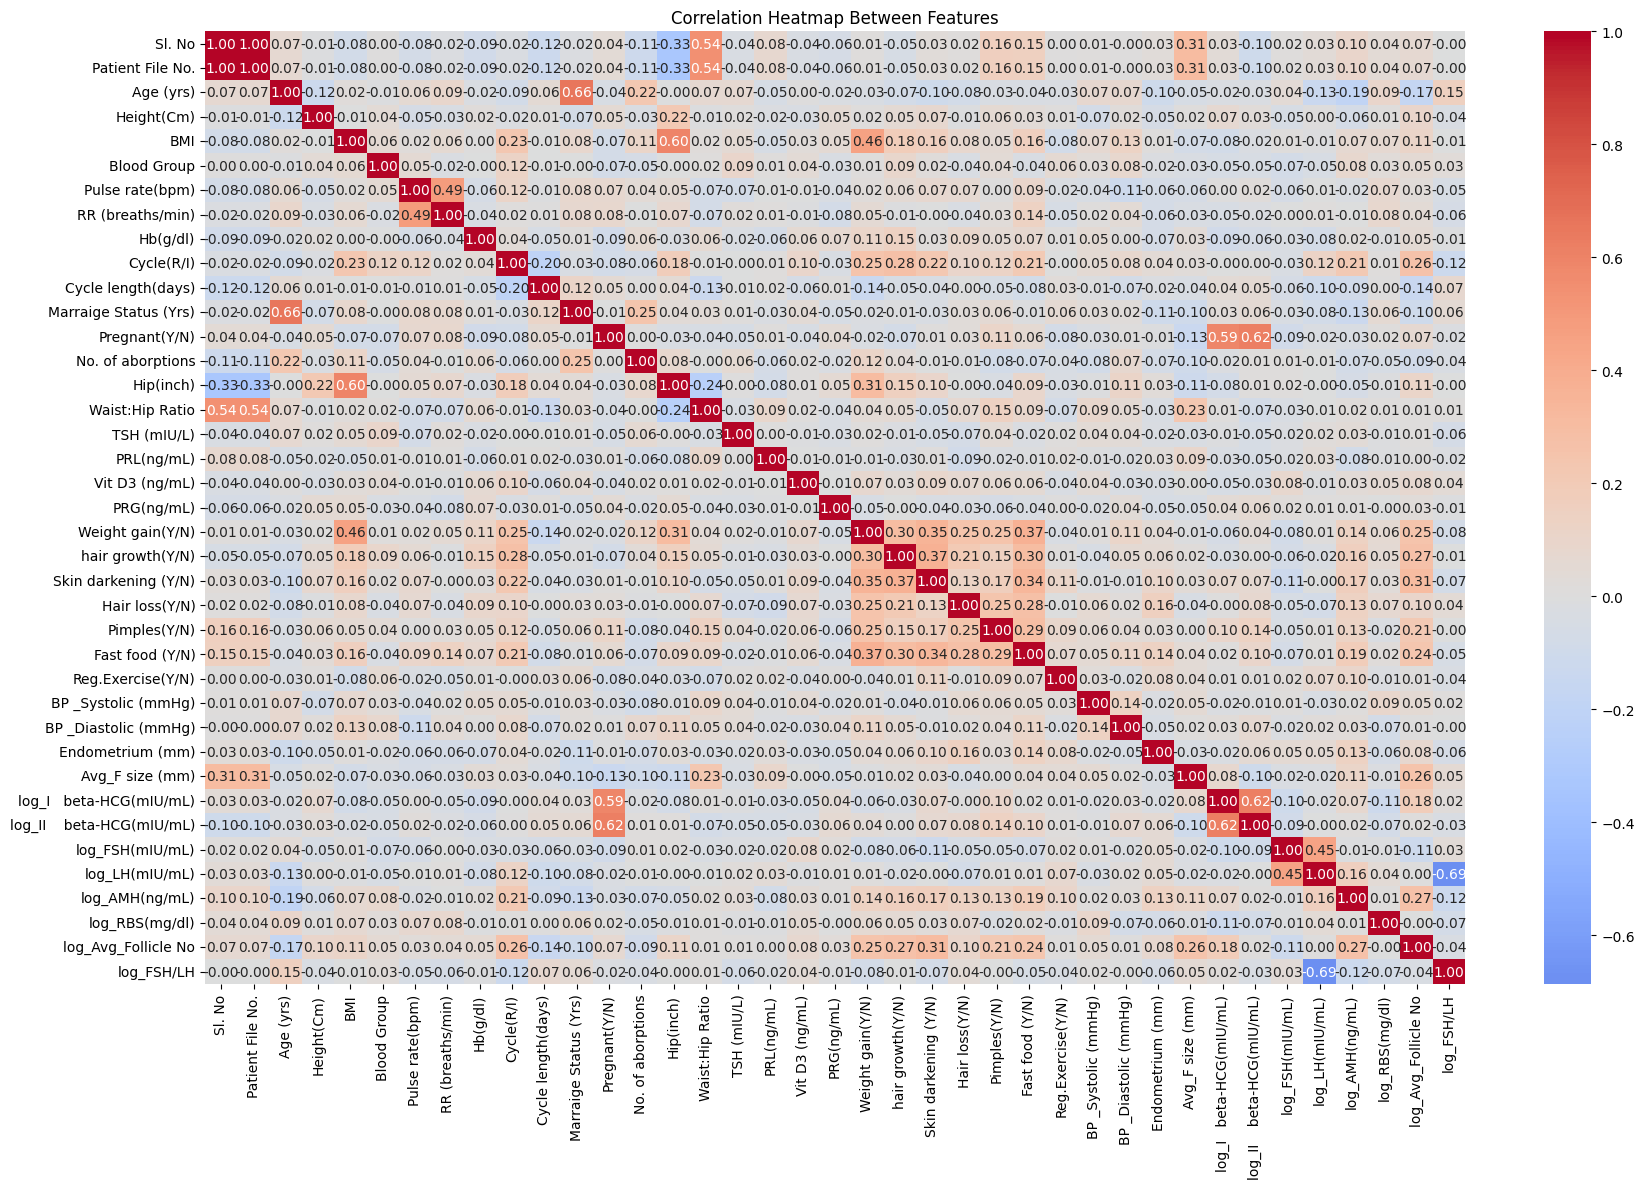

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix (feature-to-feature)
corr_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Heatmap Between Features')
plt.tight_layout()
plt.show()


### Multicollinearity check with VIF


In [ ]:
def calculate_vif(df, features):
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i)
                      for i in range(len(features))]
    return vif_data

vif_data = calculate_vif(X, significant_features)
features_no_multicol = vif_data[vif_data['VIF'] <= 10]['feature'].tolist()
print(len(features_no_multicol), "Features after multicollinearity check:", features_no_multicol)

8 Features after multicollinearity check: ['Marraige Status (Yrs)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)', 'log_AMH(ng/mL)']


### Keeping the clinical features in if not selected

In [ ]:
# But we keep ['LH(mIU/mL)', 'FSH/LH', 'AMH(ng/mL)', 'Avg_Follicle No'] as these are necessary clinical features
for item in ['log_LH(mIU/mL)', 'log_FSH/LH', 'log_Avg_Follicle No']:
  if item not in features_no_multicol:
    features_no_multicol.append(item)

print(len(features_no_multicol), "Features after multicollinearity check and adding must keep features:", features_no_multicol)

11 Features after multicollinearity check and adding must keep features: ['Marraige Status (Yrs)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)', 'log_AMH(ng/mL)', 'log_LH(mIU/mL)', 'log_FSH/LH', 'log_Avg_Follicle No']


### Now we use RFECV and stratifiedKfold method to eliminate features while checking if balance is maintained in the 'K' folds. (Recurrsive feature elimination with cross validation) It automaticaaly stops when removing features degrades the model quality.

In [ ]:
from sklearn.model_selection import StratifiedKFold

# 7.  RFE feature importance
logreg = LogisticRegression(max_iter=1000)
# rfe = RFE(logreg, n_features_to_select='auto', step=1)
# rfe.fit(X[features_no_multicol], y)
# final_features = X[features_no_multicol].columns[rfe.support_].tolist()

# print("Final selected features:", final_features)
from sklearn.feature_selection import RFECV
rfecv = RFECV(logreg, step=1, cv=StratifiedKFold(5), scoring='roc_auc', min_features_to_select=6)  # Automatically selects optimal features
rfecv.fit(X[features_no_multicol], y)
final_features = X[features_no_multicol].columns[rfecv.support_].tolist()

In [ ]:
# But we keep ['LH(mIU/mL)', 'FSH/LH', 'AMH(ng/mL)', 'Avg_Follicle No'] as these are necessary clinical features
for item in ['log_LH(mIU/mL)', 'log_FSH/LH', 'log_Avg_Follicle No']:
  if item not in final_features:
    final_features.append(item)

print(len(final_features), "Features after multicollinearity check and adding must keep features:", features_no_multicol)

8 Features after multicollinearity check and adding must keep features: ['Marraige Status (Yrs)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)', 'log_AMH(ng/mL)', 'log_LH(mIU/mL)', 'log_FSH/LH', 'log_Avg_Follicle No']


This all gave us a good idea about the importance of featuers and where to focus on .

# Modeling

### 1. Preprocessing + Split

In [ ]:
final_features

['Weight gain(Y/N)',
 'hair growth(Y/N)',
 'Skin darkening (Y/N)',
 'Pimples(Y/N)',
 'Fast food (Y/N)',
 'log_LH(mIU/mL)',
 'log_Avg_Follicle No',
 'log_FSH/LH']

In [ ]:
X.columns

Index(['Sl. No', 'Patient File No.', 'Age (yrs)', 'Height(Cm)', 'BMI',
       'Blood Group', 'Pulse rate(bpm)', 'RR (breaths/min)', 'Hb(g/dl)',
       'Cycle(R/I)', 'Cycle length(days)', 'Marraige Status (Yrs)',
       'Pregnant(Y/N)', 'No. of aborptions', 'Hip(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'PRG(ng/mL)',
       'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)',
       'Hair loss(Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)',
       'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)', 'BP _Diastolic (mmHg)',
       'Endometrium (mm)', 'Avg_F size (mm)', 'log_I   beta-HCG(mIU/mL)',
       'log_II    beta-HCG(mIU/mL)', 'log_FSH(mIU/mL)', 'log_LH(mIU/mL)',
       'log_AMH(ng/mL)', 'log_RBS(mg/dl)', 'log_Avg_Follicle No',
       'log_FSH/LH'],
      dtype='object')

In [ ]:


data = df_2.copy()

# Drop ID-type columns
X = data.drop(columns=["Sl. No", "Patient File No.", "PCOS (Y/N)"])

# Define features and target
# X = data.drop(columns=["PCOS (Y/N)"])
# X = data[final_features]
y = data["PCOS (Y/N)"]

# Train/Test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Training set class distribution:\n", y_train.value_counts())
print("Test set class distribution:\n", y_test.value_counts())

Training set class distribution:
 PCOS (Y/N)
0    291
1    141
Name: count, dtype: int64
Test set class distribution:
 PCOS (Y/N)
0    73
1    36
Name: count, dtype: int64


## 2. SMOTE + Scaling


In [ ]:
# Base pipeline (scaler + SMOTE)
scaler = StandardScaler()
smote = SMOTE(random_state=42)


### Dummy baseline

In [ ]:


# Train dummy model (no scaling or SMOTE)
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

# Evaluate
print("=== Dummy Baseline Model ===")
print(classification_report(y_test, y_pred_dummy, zero_division=0))



=== Dummy Baseline Model ===
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        73
           1       0.00      0.00      0.00        36

    accuracy                           0.67       109
   macro avg       0.33      0.50      0.40       109
weighted avg       0.45      0.67      0.54       109



# Logistic Regression

#### 1.1. Untuned Logistic Regression







In [ ]:
# Define pipeline with scaling, SMOTE, and Logistic Regression
lr_untuned_pipeline = Pipeline([
    ('scale', scaler),
    ('smote', smote),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))  # max_iter added to ensure convergence
])

# Set up cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use weighted recall score as the evaluation metric
weighted_recall = make_scorer(recall_score, average='weighted')

# Evaluate using cross-validation on the training set
scores = cross_val_score(lr_untuned_pipeline, X_train, y_train, cv=cv, scoring=weighted_recall)

# Report cross-validation results
print("=== Untuned Logistic Regression (Cross-Validation on train dataset) ===")
print(f"Mean recall Score: {scores.mean():.3f} ± {scores.std():.3f}")

# Fit the model on the full training set
lr_untuned_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred_baseline = lr_untuned_pipeline.predict(X_test)

# Report test set performance
print("=== Untuned Logistic Regression (Test Set) ===")
print(classification_report(y_test, y_pred_baseline))


=== Untuned Logistic Regression (Cross-Validation on train dataset) ===
Mean recall Score: 0.868 ± 0.039
=== Untuned Logistic Regression (Test Set) ===
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        73
           1       0.82      0.86      0.84        36

    accuracy                           0.89       109
   macro avg       0.87      0.88      0.88       109
weighted avg       0.89      0.89      0.89       109



#### 1.2. Tuned Logistic Regression

In [ ]:
# Split param grids
param_grid = [
    {
        'clf__penalty': ['l1'],
        'clf__C': [0.1, 0.5, 1, 2, 5],
        'clf__solver': ['saga'],
        'clf__class_weight': ['balanced'],

    },
    {
        'clf__penalty': ['l2'],
        'clf__C': [0.1, 0.5, 1, 2, 5],
        'clf__solver': ['saga'],
        'clf__class_weight': ['balanced'],

    },
    {
        'clf__penalty': ['elasticnet'],
        'clf__C': [0.1, 0.5, 1, 2, 5],
        'clf__solver': ['saga'],
        'clf__l1_ratio': [0.5, 0.6, 0.7, 0.75, 0.8, 0.9],
        'clf__class_weight': ['balanced'],

    }
]

# Grid search
lr_grid = GridSearchCV(
    estimator=lr_untuned_pipeline,
    param_grid=param_grid,
    scoring=weighted_recall,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit grid search
lr_grid.fit(X_train, y_train)
print("✅ Best Logistic Regression Params:", lr_grid.best_params_)

# Get best estimator (automatically fitted!)
lr_tuned_pipeline = lr_grid.best_estimator_

# Evaluate on training set with cross-validation
y_train_pred_lr_cv = cross_val_predict(lr_tuned_pipeline, X_train, y_train, cv=cv, n_jobs=-1)

print("\n=== Cross-Validated Performance - Tuned Logistic Regression ===")
print(classification_report(y_train, y_train_pred_lr_cv))

# Evaluate on test set
y_test_pred_lr = lr_tuned_pipeline.predict(X_test)
print("\n=== Test Set Performance - Tuned Logistic Regression ===")
print(classification_report(y_test, y_test_pred_lr))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
✅ Best Logistic Regression Params: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__l1_ratio': 0.8, 'clf__penalty': 'elasticnet', 'clf__solver': 'saga'}

=== Cross-Validated Performance - Tuned Logistic Regression ===
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       291
           1       0.82      0.86      0.84       141

    accuracy                           0.89       432
   macro avg       0.87      0.88      0.88       432
weighted avg       0.89      0.89      0.89       432


=== Test Set Performance - Tuned Logistic Regression ===
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        73
           1       0.89      0.89      0.89        36

    accuracy                           0.93       109
   macro avg       0.92      0.92      0.92       109
weighted avg       0.93      0.93      0.93       109



## Feature Importance - LR

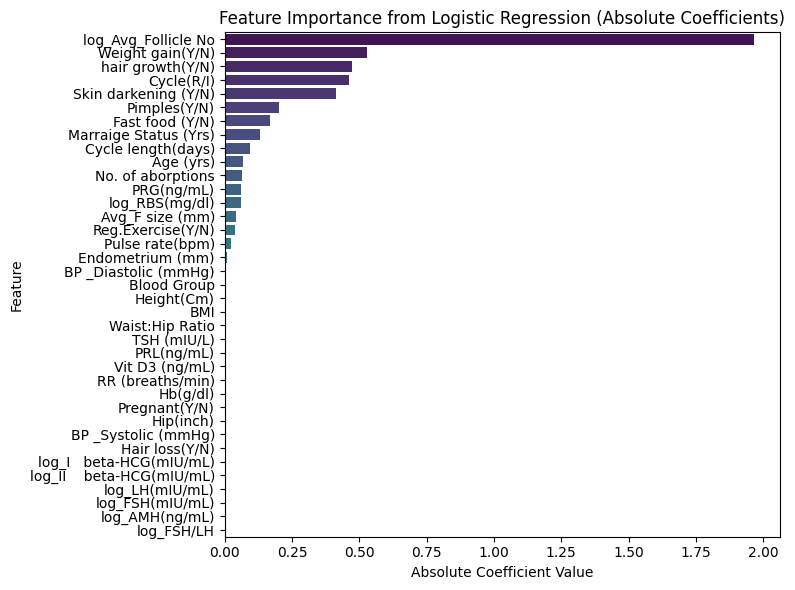

In [ ]:
# Extract feature names (assuming X_train is a DataFrame)
feature_names = X_train.columns

# Get the coefficients from the best estimator
coefficients = lr_tuned_pipeline.named_steps['clf'].coef_[0]

# Create DataFrame for plotting
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

# Sort by absolute coefficient value
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)


# Plot
plt.figure(figsize=(8,6))
sns.barplot(x='Abs_Coefficient', y='Feature', hue='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance from Logistic Regression (Absolute Coefficients)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### Retrain the model with different subsets of important features to find the best - LR



In [ ]:
results = []  # Reset the list before the loop
feature_subsets = list(range(1, len(feature_importance) + 1))  # [1, 2, 3, ..., N] recall

# Then use it in your loop:
for top_n in feature_subsets:
    top_features = feature_importance['Feature'].head(top_n).tolist()

    X_train_top = X_train[top_features]
    X_test_top = X_test[top_features]

    y_train_pred_cv_top = cross_val_predict(lr_tuned_pipeline, X_train_top, y_train, cv=cv, n_jobs=-1)
    cv_report = classification_report(y_train, y_train_pred_cv_top, output_dict=True)

    lr_tuned_pipeline.fit(X_train_top, y_train)
    y_test_pred_top = lr_tuned_pipeline.predict(X_test_top)
    test_report = classification_report(y_test, y_test_pred_top, output_dict=True)

    results.append({
    'Top_N_Features': top_n,
    'Train_recall_Score': cv_report['weighted avg']['recall'],  # weighted average recall on train
    'Test_recall_Score': test_report['weighted avg']['recall'],  # weighted average recall on test
    'Train_Accuracy': cv_report['accuracy'],
    'Test_Accuracy': test_report['accuracy']
})


# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

    Top_N_Features  Train_recall_Score  Test_recall_Score  Train_Accuracy  \
0                1            0.819444           0.816514        0.819444   
1                2            0.847222           0.834862        0.847222   
2                3            0.851852           0.834862        0.851852   
3                4            0.872685           0.899083        0.872685   
4                5            0.881944           0.899083        0.881944   
5                6            0.888889           0.926606        0.888889   
6                7            0.881944           0.926606        0.881944   
7                8            0.891204           0.926606        0.891204   
8                9            0.888889           0.917431        0.888889   
9               10            0.881944           0.917431        0.881944   
10              11            0.877315           0.917431        0.877315   
11              12            0.881944           0.917431        0.881944   

### Retrain the model with important features and compare it with all features - LR


In [ ]:
# === Get best feature subset === recall
best_subset_lr = results_df.loc[results_df['Test_recall_Score'].idxmax()]
best_top_n_lr = int(best_subset_lr['Top_N_Features'])
top_features_best_lr = feature_importance.iloc[:best_top_n_lr]['Feature'].tolist()

# === Subset data ===
X_train_best_lr = X_train[top_features_best_lr]
X_test_best_lr = X_test[top_features_best_lr]

# === train model best feature subset ===


lr_tuned_pipeline.fit(X_train_best_lr, y_train)
y_test_pred_best = lr_tuned_pipeline.predict(X_test_best_lr)

print("=== Test Set Performance (Logistic Regression - Best Feature Subset) ===")
print(classification_report(y_test, y_test_pred_best))

# === train model with all features ===

lr_tuned_pipeline.fit(X_train, y_train)
y_test_pred_all = lr_tuned_pipeline.predict(X_test)

print("=== Test Set Performance (Logistic Regression - All Features) ===")
print(classification_report(y_test, y_test_pred_all))


=== Test Set Performance (Logistic Regression - Best Feature Subset) ===
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        73
           1       0.91      0.89      0.90        36

    accuracy                           0.94       109
   macro avg       0.93      0.92      0.93       109
weighted avg       0.94      0.94      0.94       109

=== Test Set Performance (Logistic Regression - All Features) ===
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        73
           1       0.89      0.89      0.89        36

    accuracy                           0.93       109
   macro avg       0.92      0.92      0.92       109
weighted avg       0.93      0.93      0.93       109



## Compare performance

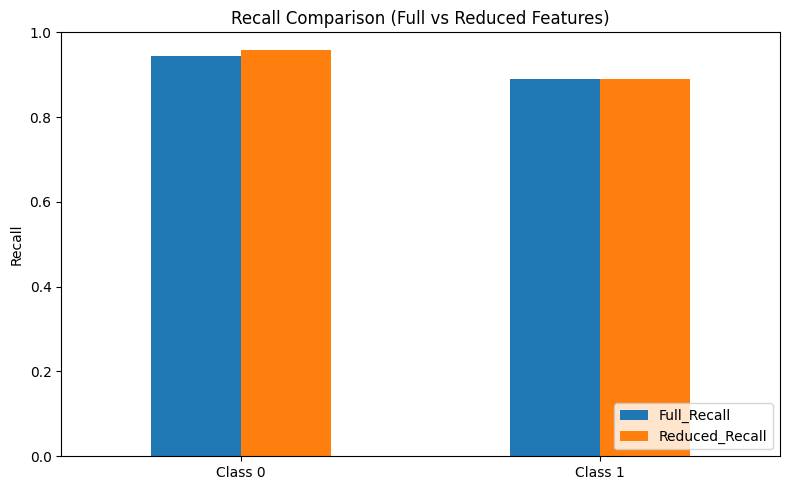

In [ ]:

# Full model
report_full = classification_report(y_test, y_test_pred_lr, output_dict=True)
df_full = pd.DataFrame(report_full).transpose()

# Reduced model
report_reduced = classification_report(y_test, y_test_pred_best, output_dict=True)
df_reduced = pd.DataFrame(report_reduced).transpose()

# Compare precision, recall, f1-score for each class
metrics = ['precision', 'recall', 'f1-score']
classes = ['0', '1']  # assuming binary classification

comparison = pd.DataFrame({
    'Full_Precision': [df_full.loc[c]['precision'] for c in classes],
    'Reduced_Precision': [df_reduced.loc[c]['precision'] for c in classes],
    'Full_Recall': [df_full.loc[c]['recall'] for c in classes],
    'Reduced_Recall': [df_reduced.loc[c]['recall'] for c in classes],
    'Full_F1': [df_full.loc[c]['f1-score'] for c in classes],
    'Reduced_F1': [df_reduced.loc[c]['f1-score'] for c in classes],
}, index=[f'Class {c}' for c in classes])

# Plot comparison
comparison[['Full_Recall', 'Reduced_Recall']].plot(kind='bar', figsize=(8, 5))
plt.title('Recall Comparison (Full vs Reduced Features)')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Decision Tree

### Untuned Decision Tree

In [ ]:
# Baseline Decision Tree pipeline
dt_untuned_pipeline = Pipeline([
    ('smote', smote),
    ('clf', DecisionTreeClassifier( random_state=42))
])

# Set up cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use weighted recall score as the evaluation metric
weighted_recall = make_scorer(recall_score, average='weighted')

# Evaluate using cross-validation on the training set
scores = cross_val_score(dt_untuned_pipeline, X_train, y_train, cv=cv, scoring=weighted_recall)

# Report results
print("=== Untuned Decision Tree (Cross-Validation) ===")
print(f"Mean recall Score: {scores.mean():.3f} ± {scores.std():.3f}")
# Fit the model on all training data
dt_untuned_pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred = dt_untuned_pipeline.predict(X_test)
print("=== Untuned Decision Tree (Test Set) ===")
print(classification_report(y_test, y_pred))


=== Untuned Decision Tree (Cross-Validation) ===
Mean recall Score: 0.794 ± 0.053
=== Untuned Decision Tree (Test Set) ===
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        73
           1       0.68      0.72      0.70        36

    accuracy                           0.80       109
   macro avg       0.77      0.78      0.77       109
weighted avg       0.80      0.80      0.80       109



### Tuned Decision Tree


In [ ]:
# Hyperparameters for GridSearchCV
dt_params = {
    'clf__criterion': ['gini', 'entropy', 'log_loss'],
    'clf__max_depth': [5,10,15,20],
    'clf__min_samples_leaf': [1, 2, 4, 6, 8],
    'clf__min_samples_split': [2, 5, 10],
    'clf__max_features': ['sqrt', 'log2']
}

# GridSearchCV for hyperparameter tuning
dt_grid = GridSearchCV(
    dt_untuned_pipeline,
    param_grid=dt_params,
    scoring=weighted_recall,
    cv=cv,
    n_jobs=-1,
    verbose=1
)
#recall
# Fit grid search to find the best model
dt_grid.fit(X_train, y_train)

# Get best model (best estimator)
dt_tuned_pipeline = dt_grid.best_estimator_
best_dt_params = dt_grid.best_params_
print("Best Decision Tree Params:", best_dt_params)

# Feature importances from the best decision tree
feature_importance = dt_tuned_pipeline.named_steps['clf'].feature_importances_

# Evaluate the model performance on the training set (no need to use cross_val_predict)
y_train_pred_dt = dt_tuned_pipeline.predict(X_train)

# Performance on the training set
print("=== Training Set Performance (Tuned Decision Tree) ===")
print(classification_report(y_train, y_train_pred_dt))

# Evaluate the model on the test set
y_test_pred_dt = dt_tuned_pipeline.predict(X_test)

# Test set performance
print("=== Test Set Performance (Tuned Decision Tree) ===")
print(classification_report(y_test, y_test_pred_dt))



Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Decision Tree Params: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}
=== Training Set Performance (Tuned Decision Tree) ===
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       291
           1       0.97      0.87      0.91       141

    accuracy                           0.95       432
   macro avg       0.95      0.93      0.94       432
weighted avg       0.95      0.95      0.95       432

=== Test Set Performance (Tuned Decision Tree) ===
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        73
           1       0.81      0.58      0.68        36

    accuracy                           0.82       109
   macro avg       0.81      0.76      0.77       109
weighted avg       0.82      0.82      0.81       109



### Feature importance - Decision Tree


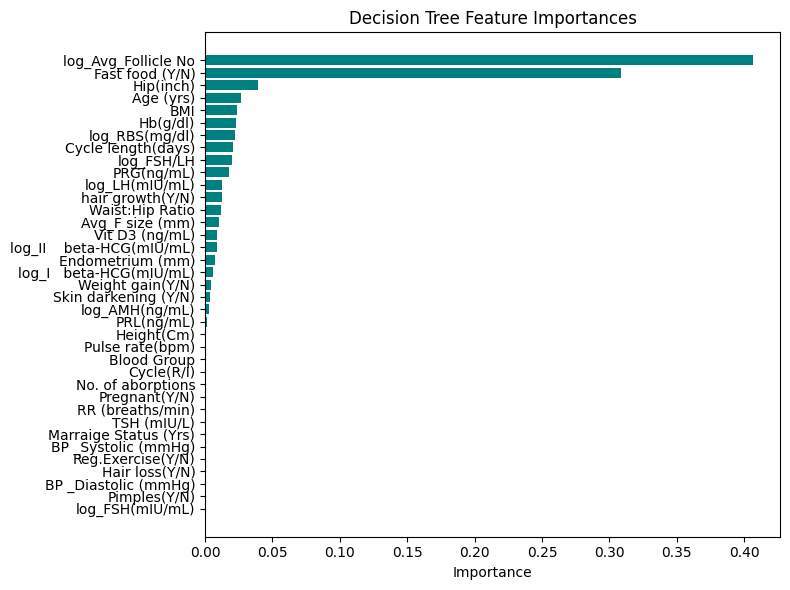

In [ ]:
# Get feature names (if using scaler, make sure you have access to original feature names)
feature_names = X_train.columns
# Create DataFrame for easy sorting and visualization
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8,6))
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='teal')
plt.xlabel('Importance')
plt.title('Decision Tree Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Retrain the model with different subsets of important features to find the best - DT

In [ ]:
# List of feature subsets to test (from 1 feature to N features)
feature_subsets = list(range(1, X_train.shape[1] + 1))

# To store results
results = []

# Iterate over different numbers of top features to test
for top_n in feature_subsets:
    top_features = feat_importance_df['Feature'].head(top_n).tolist()  # Get top `top_n` features

    # Subset the data based on the selected features
    X_train_top = X_train[top_features]
    X_test_top = X_test[top_features]

    # Cross-validated predictions for training set
    y_train_pred_cv_top = cross_val_predict(dt_tuned_pipeline, X_train_top, y_train, cv=cv, n_jobs=-1)

    # Evaluate cross-validation performance
    cv_report = classification_report(y_train, y_train_pred_cv_top, output_dict=True)

    # Fit the model with the full training set and make predictions on the test set
    dt_tuned_pipeline.fit(X_train_top, y_train)
    y_test_pred_top = dt_tuned_pipeline.predict(X_test_top)

    # Evaluate test performance
    test_report = classification_report(y_test, y_test_pred_top, output_dict=True)

    # Store results
    results.append({
        'Top_N_Features': top_n,
        'Train_recall_Score': cv_report['weighted avg']['recall'],  # weighted average recall on train
        'Test_recall_Score': test_report['weighted avg']['recall'],  # weighted average recall on test
        'Train_Accuracy': cv_report['accuracy'],
        'Test_Accuracy': test_report['accuracy']
    })


# Convert results into a DataFrame for easy comparison
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


    Top_N_Features  Train_recall_Score  Test_recall_Score  Train_Accuracy  \
0                1            0.807870           0.844037        0.807870   
1                2            0.819444           0.862385        0.819444   
2                3            0.835648           0.871560        0.835648   
3                4            0.803241           0.816514        0.803241   
4                5            0.768519           0.798165        0.768519   
5                6            0.780093           0.743119        0.780093   
6                7            0.784722           0.752294        0.784722   
7                8            0.796296           0.834862        0.796296   
8                9            0.796296           0.816514        0.796296   
9               10            0.763889           0.807339        0.763889   
10              11            0.733796           0.743119        0.733796   
11              12            0.803241           0.798165        0.803241   

### Retrain the model with important features and compare it with all features - DT

In [ ]:
# Find the subset with the highest test recall score
best_subset = results_df.loc[results_df['Test_recall_Score'].idxmax()]

# Ensure best_top_n is an integer (check type if needed)
best_top_n = int(best_subset['Top_N_Features'])

# Ensure you are using `.iloc[]` for positional indexing
top_features_best = feat_importance_df.iloc[:best_top_n]['Feature'].tolist()

# Now, top_features_best should be a list of the top N features

# Subset the data based on the top features
X_train_best_dt = X_train[top_features_best]
X_test_best_dt = X_test[top_features_best]

# Fit the model with the best feature subset and make predictions on the test set
dt_tuned_pipeline.fit(X_train_best_dt, y_train)
y_test_pred_best = dt_tuned_pipeline.predict(X_test_best_dt)

# Evaluate test performance
print("=== Test Set Performance (Best Feature Subset) ===")
print(classification_report(y_test, y_test_pred_best))


# Fit and predict on the test set using all features
dt_tuned_pipeline.fit(X_train, y_train)
y_test_pred_all = dt_tuned_pipeline.predict(X_test)

# Evaluate test performance on all features
print("=== Test Set Performance (All Features) ===")
print(classification_report(y_test, y_test_pred_all))


=== Test Set Performance (Best Feature Subset) ===
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        73
           1       0.81      0.83      0.82        36

    accuracy                           0.88       109
   macro avg       0.86      0.87      0.87       109
weighted avg       0.88      0.88      0.88       109

=== Test Set Performance (All Features) ===
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        73
           1       0.81      0.58      0.68        36

    accuracy                           0.82       109
   macro avg       0.81      0.76      0.77       109
weighted avg       0.82      0.82      0.81       109



# Random Forest

### 3.1. Untuned Random Forest

In [ ]:
# Define the baseline Random Forest pipeline
rf_untuned_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

# Set up cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use weighted recall score as the evaluation metric
weighted_recall = make_scorer(recall_score, average='weighted')

# Evaluate using cross-validation on the training set
scores = cross_val_score(rf_untuned_pipeline, X_train, y_train, cv=cv, scoring=weighted_recall)

# Report results
print("=== Untuned Random Forest (Cross-Validation) ===")
print(f"Mean recall Score: {scores.mean():.3f} ± {scores.std():.3f}")

# Fit the model on all training data
rf_untuned_pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred_rf_base = rf_untuned_pipeline.predict(X_test)
print("=== Untuned Random Forest (Test Set) ===")
print(classification_report(y_test, y_pred_rf_base))


=== Untuned Random Forest (Cross-Validation) ===
Mean recall Score: 0.903 ± 0.027
=== Untuned Random Forest (Test Set) ===
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        73
           1       0.89      0.86      0.87        36

    accuracy                           0.92       109
   macro avg       0.91      0.90      0.91       109
weighted avg       0.92      0.92      0.92       109



### 2.2. Hyperparameter Tuning – Random Forest


In [ ]:
# Parameter grid
rf_params = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [10, 15],
    'clf__min_samples_split': [2,4],
    'clf__min_samples_leaf': [1,2,4],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__bootstrap': [True],
    'clf__class_weight': ['balanced']
}

# Grid search
rf_grid = GridSearchCV(
    rf_untuned_pipeline,
    param_grid=rf_params,
    scoring=weighted_recall,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

# Fit
rf_grid.fit(X_train, y_train)

# Extract best parameters and estimator
best_rf_params = rf_grid.best_params_
print("Best Random Forest Params:", best_rf_params)
rf_tuned_pipeline = rf_grid.best_estimator_

# Feature importances from the best random forest
feature_importance = rf_tuned_pipeline.named_steps['clf'].feature_importances_

# Evaluate the model performance on the training set (no need to use cross_val_predict)
y_train_pred_rf = rf_tuned_pipeline.predict(X_train)

# Performance on the training set
print("=== Training Set Performance (Tuned Random Forest) ===")
print(classification_report(y_train, y_train_pred_rf))

# Evaluate the model on the test set
y_test_pred_rf = rf_tuned_pipeline.predict(X_test)

# Test set performance
print("=== Test Set Performance (Tuned Random Forest) ===")
print(classification_report(y_test, y_test_pred_rf))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Random Forest Params: {'clf__bootstrap': True, 'clf__class_weight': 'balanced', 'clf__max_depth': 15, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
=== Training Set Performance (Tuned Random Forest) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       141

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432

=== Test Set Performance (Tuned Random Forest) ===
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        73
           1       0.89      0.86      0.87        36

    accuracy                           0.92       109
   macro avg       0.91      0.90      0.91       109
weighted avg  

### Feature importance - Random Forest


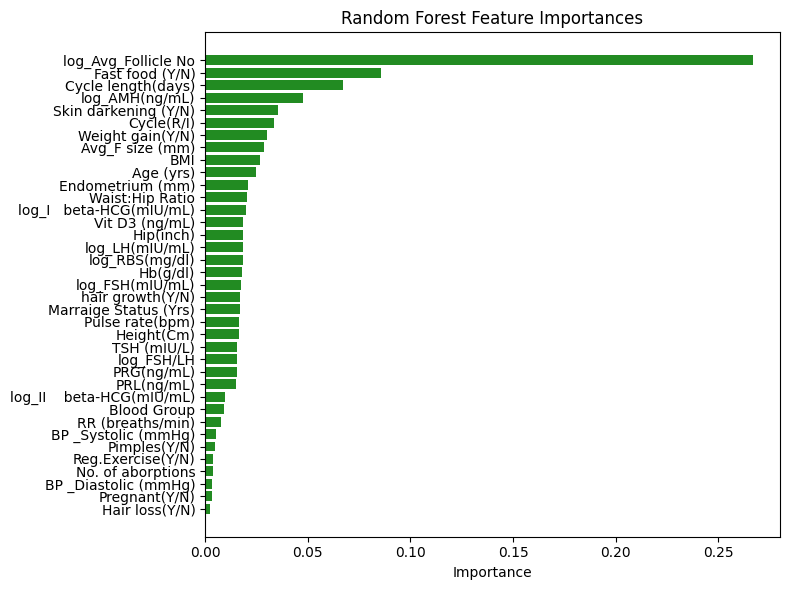

In [ ]:
# Get feature importances
feature_importance = rf_tuned_pipeline.named_steps['clf'].feature_importances_

# Get feature names (if using a scaler, make sure original column names are preserved)
feature_names = X_train.columns

# Create a DataFrame for easy sorting and visualization
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot the importances
plt.figure(figsize=(8,6))
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='forestgreen')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Retrain the model with different subsets of important features to find the best - RF

In [ ]:
# List of feature subsets to test
feature_subsets = list(range(1, len(feat_importance_df) + 1))

# Ensure features are sorted in descending importance
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# To store results
results_rf = []

# Loop over different numbers of top features
for top_n in feature_subsets:
    top_features = feat_importance_df['Feature'].head(top_n).tolist()

    # Subset data
    X_train_top = X_train[top_features]
    X_test_top = X_test[top_features]

    # Cross-validation prediction on training set
    y_train_pred_cv_top = cross_val_predict(rf_tuned_pipeline, X_train_top, y_train, cv=cv, n_jobs=-1)

    # Evaluate on training
    cv_report = classification_report(y_train, y_train_pred_cv_top, output_dict=True)

    # Fit on training and predict on test
    rf_tuned_pipeline.fit(X_train_top, y_train)
    y_test_pred_top = rf_tuned_pipeline.predict(X_test_top)
    test_report = classification_report(y_test, y_test_pred_top, output_dict=True)

    results_rf.append({
    'Top_N_Features': top_n,
    'Train_recall_Score': cv_report['weighted avg']['recall'],  # weighted avg recall on train
    'Test_recall_Score': test_report['weighted avg']['recall'],  # weighted avg recall on test
    'Train_Accuracy': cv_report['accuracy'],
    'Test_Accuracy': test_report['accuracy']
})


# Create results DataFrame
results_rf_df = pd.DataFrame(results_rf)

# Show results
print(results_rf_df)


    Top_N_Features  Train_recall_Score  Test_recall_Score  Train_Accuracy  \
0                1            0.807870           0.825688        0.807870   
1                2            0.835648           0.862385        0.835648   
2                3            0.849537           0.871560        0.849537   
3                4            0.833333           0.844037        0.833333   
4                5            0.872685           0.899083        0.872685   
5                6            0.877315           0.899083        0.877315   
6                7            0.900463           0.899083        0.900463   
7                8            0.879630           0.908257        0.879630   
8                9            0.875000           0.899083        0.875000   
9               10            0.879630           0.899083        0.879630   
10              11            0.884259           0.917431        0.884259   
11              12            0.875000           0.908257        0.875000   

### Retrain the model with important features and compare it with all features - RF

In [ ]:
# === Get the best performing feature subset based on test recall score ===
best_subset_rf = results_rf_df.loc[results_rf_df['Test_recall_Score'].idxmax()]
best_top_n_rf = int(best_subset_rf['Top_N_Features'])

# Get top N features from feature importance
top_features_best_rf = feat_importance_df.iloc[:best_top_n_rf]['Feature'].tolist()

# Subset the data
X_train_best_rf = X_train[top_features_best_rf]
X_test_best_rf = X_test[top_features_best_rf]


# Fit and evaluate on best feature subset
rf_tuned_pipeline.fit(X_train_best_rf, y_train)
y_test_pred_best_rf = rf_tuned_pipeline.predict(X_test_best_rf)

print("=== Test Set Performance (Random Forest - Best Feature Subset) ===")
print(classification_report(y_test, y_test_pred_best_rf))

# Fit and evaluate on all features
rf_tuned_pipeline.fit(X_train, y_train)
y_test_pred_all_rf = rf_tuned_pipeline.predict(X_test)

print("=== Test Set Performance (Random Forest - All Features) ===")
print(classification_report(y_test, y_test_pred_all_rf))


=== Test Set Performance (Random Forest - Best Feature Subset) ===
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        73
           1       0.94      0.83      0.88        36

    accuracy                           0.93       109
   macro avg       0.93      0.90      0.91       109
weighted avg       0.93      0.93      0.93       109

=== Test Set Performance (Random Forest - All Features) ===
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        73
           1       0.89      0.86      0.87        36

    accuracy                           0.92       109
   macro avg       0.91      0.90      0.91       109
weighted avg       0.92      0.92      0.92       109



### 3.4. Finding best max_depth

In [ ]:
# from sklearn.metrics import make_scorer, recall_score
# # Best parameters from your grid search (except max_depth)
# max_depths = [3, 5, 10, 15, 20, 30, 50, None]
# recall_scores = []

# for depth in max_depths:
#     model = Pipeline([
#         ('scale', scaler),
#         ('smote', smote),
#         ('clf', RandomForestClassifier(
#             n_estimators=best_rf_params['clf__n_estimators'],
#             min_samples_split=best_rf_params['clf__min_samples_split'],
#             min_samples_leaf=best_rf_params['clf__min_samples_leaf'],
#             bootstrap=best_rf_params['clf__bootstrap'],
#             class_weight=best_rf_params['clf__class_weight'],
#             max_depth=depth,
#             random_state=42,
#             n_jobs=-1,
#         ))
#     ])

#     weighted_recall = make_scorer(recall_score, average='weighted')
#     scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=weighted_recall, n_jobs=-1, error_score='raise')
#     recall_scores.append(np.mean(scores))

# # Plot
# plt.figure(figsize=(10, 6))
# plt.plot([str(d) for d in max_depths], recall_scores, marker='o')
# plt.title("Effect of max_depth on recall Score (Tuned RF - Cross-Validation)")
# plt.xlabel("max_depth")
# plt.ylabel("Mean recall Score")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


### 3.5. Finding best n_estimator

In [ ]:
# # Range of n_estimators to test
# n_estimators_list = [10, 50, 100, 150, 200, 300, 500]
# recall_scores = []

# for n in n_estimators_list:
#     model = Pipeline([
#         ('scale', scaler),
#         ('smote', smote),
#         ('clf', RandomForestClassifier(
#             n_estimators=n,
#             max_depth=best_rf_params['clf__max_depth'],
#             min_samples_split=best_rf_params['clf__min_samples_split'],
#             min_samples_leaf=best_rf_params['clf__min_samples_leaf'],
#             max_features=best_rf_params['clf__max_features'],
#             bootstrap=best_rf_params['clf__bootstrap'],
#             random_state=42,
#             n_jobs=-1
#         ))
#     ])
#     weighted_recall = make_scorer(recall_score, average='weighted')
#     scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=weighted_recall, n_jobs=-1, error_score='raise')
#     recall_scores.append(np.mean(scores))

# # Plot
# plt.figure(figsize=(10, 6))
# plt.plot(n_estimators_list, recall_scores, marker='o')
# plt.title("Effect of n_estimators on recall Score (Tuned RF - Cross-Validation)")
# plt.xlabel("n_estimators")
# plt.ylabel("Mean recall Score")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


# Final validation

In [ ]:
# Test sets for top-feature pipelines
X_test_map = {
    'LR Tuned (Top Features)': X_test_best_lr,
    'DT Tuned (Top Features)': X_test_best_dt,
    'RF Tuned (Top Features)': X_test_best_rf,
}
# Logistic Regression
lr_pipeline_tuned_top_features = clone(lr_tuned_pipeline)
lr_pipeline_tuned_top_features.fit(X_train_best_lr, y_train)

# Decision Tree
dt_tuned_pipeline_top_features = clone(dt_tuned_pipeline)
dt_tuned_pipeline_top_features.fit(X_train_best_dt, y_train)

# Random Forest
rf_tuned_pipeline_top_features = clone(rf_tuned_pipeline)
rf_tuned_pipeline_top_features.fit(X_train_best_rf, y_train)



# Models list
models = [
    ('Dummy', dummy),

    # Logistic Regression
    ('LR Untuned', lr_untuned_pipeline),
    ('LR Tuned (All)', lr_tuned_pipeline),
    ('LR Tuned (Top Features)', lr_pipeline_tuned_top_features),

    # Decision Tree
    ('DT Untuned', dt_untuned_pipeline),
    ('DT Tuned (All)', dt_tuned_pipeline),
    ('DT Tuned (Top Features)', dt_tuned_pipeline_top_features),

    # Random Forest
    ('RF Untuned', rf_untuned_pipeline),
    ('RF Tuned (All)', rf_tuned_pipeline),
    ('RF Tuned (Top Features)', rf_tuned_pipeline_top_features),
]



## Confusion Matrix

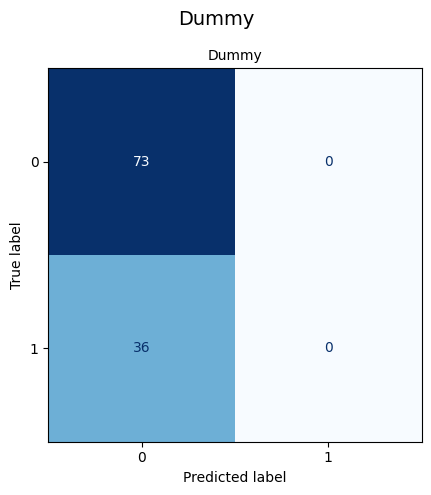

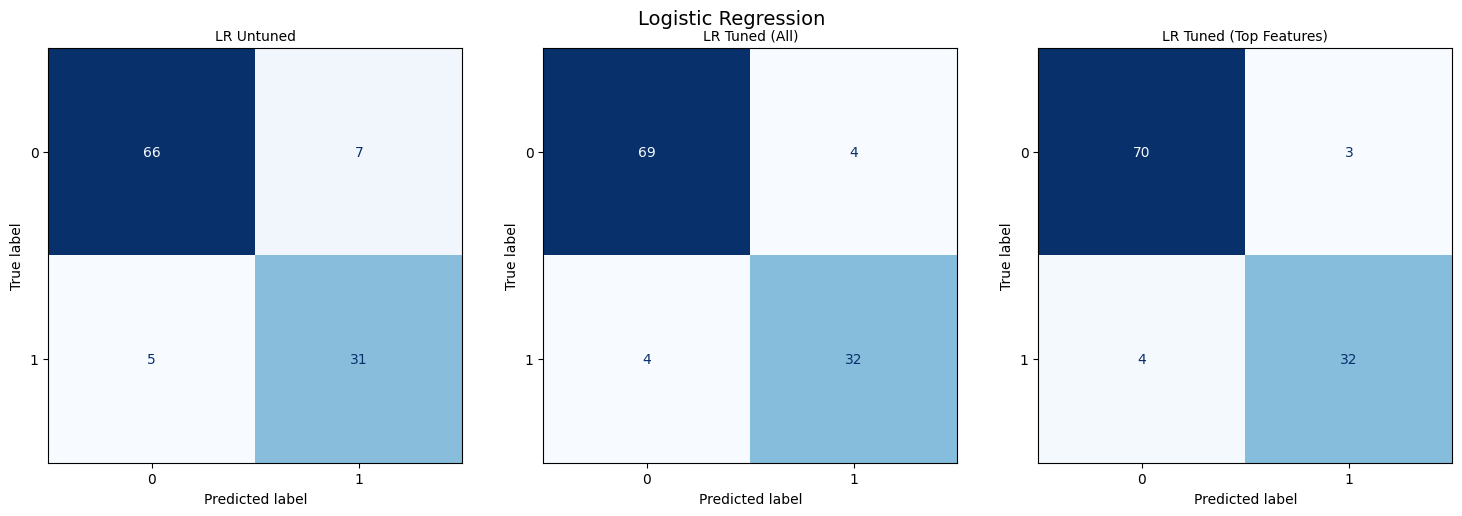

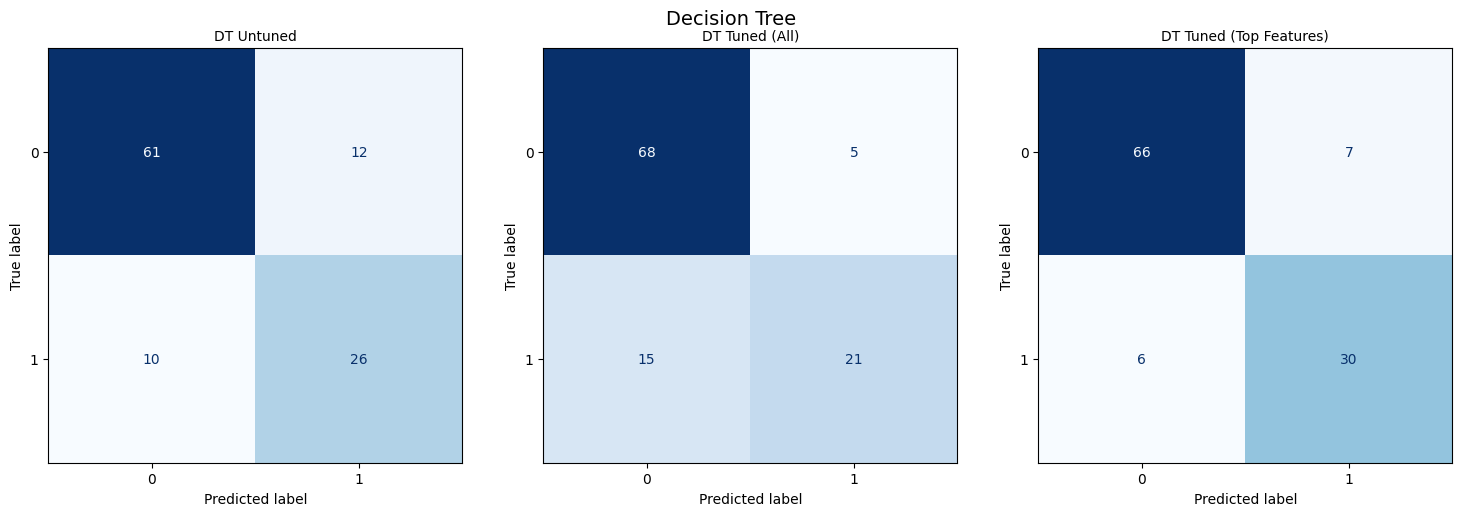

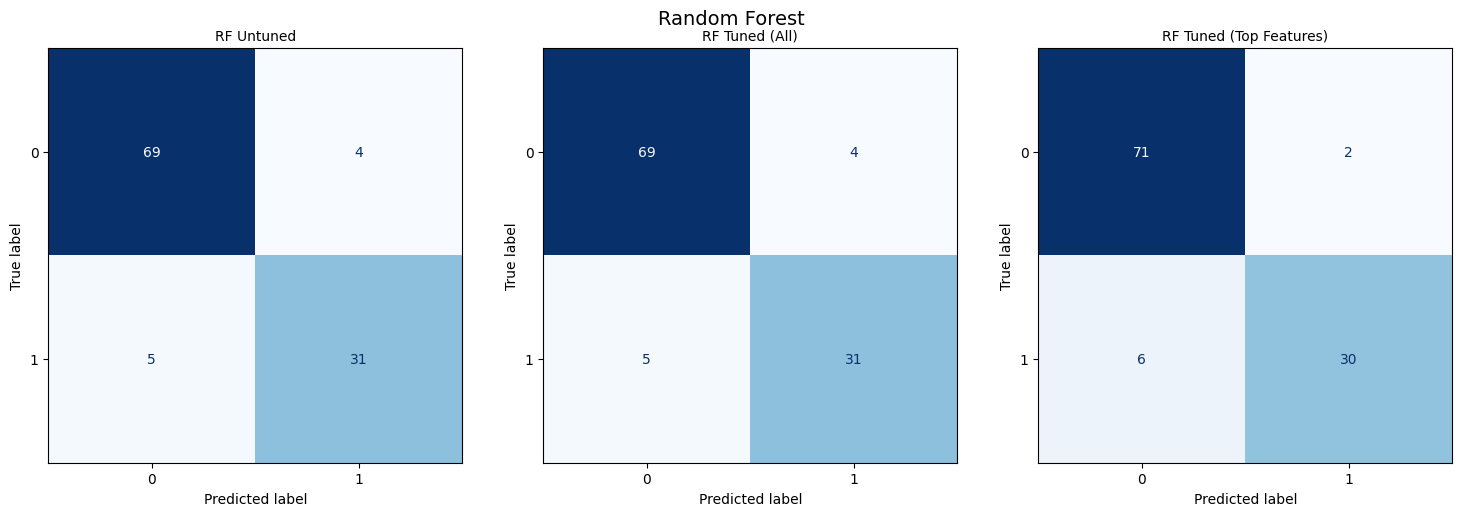

In [ ]:
# Create groups for each model type
model_groups = {
        'Dummy': [
        ('Dummy', dummy),
    ],
    'Logistic Regression': [
        ('LR Untuned', lr_untuned_pipeline),
        ('LR Tuned (All)', lr_tuned_pipeline),
        ('LR Tuned (Top Features)', lr_pipeline_tuned_top_features),
    ],
    'Decision Tree': [
        ('DT Untuned', dt_untuned_pipeline),
        ('DT Tuned (All)', dt_tuned_pipeline),
        ('DT Tuned (Top Features)', dt_tuned_pipeline_top_features),
    ],
    'Random Forest': [
        ('RF Untuned', rf_untuned_pipeline),
        ('RF Tuned (All)', rf_tuned_pipeline),
        ('RF Tuned (Top Features)', rf_tuned_pipeline_top_features),
    ]
}

# Feature-subset test sets
X_test_map = {
    'LR Tuned (Top Features)': X_test_best_lr,
    'DT Tuned (Top Features)': X_test_best_dt,
    'RF Tuned (Top Features)': X_test_best_rf,
}

# Plotting
for group_name, group_models in model_groups.items():
    n = len(group_models)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
    fig.suptitle(group_name, fontsize=14)

    # Ensure axes is a list even if there's only one plot
    if n == 1:
        axes = [axes]

    for ax, (name, model) in zip(axes, group_models):
        X_eval = X_test_map.get(name, X_test)
        disp = ConfusionMatrixDisplay.from_estimator(model, X_eval, y_test, ax=ax, cmap='Blues', colorbar=False)
        ax.set_title(name, fontsize=10)
        ax.grid(False)

    plt.tight_layout()
    plt.show()


## Classification Report

In [ ]:
for name, model in models:
    # For Dummy, we don't need top feature handling
    if name == 'Dummy':
        X_eval = X_test
    else:
        # For other models, ensure to use the top feature test set if necessary
        X_eval = X_test_map.get(name, X_test)

    # Make predictions
    y_pred = model.predict(X_eval)

    # Print classification report
    print(f"=== Classification Report for {name} ===")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("\n" + "="*60 + "\n")

=== Classification Report for Dummy ===
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        73
           1       0.00      0.00      0.00        36

    accuracy                           0.67       109
   macro avg       0.33      0.50      0.40       109
weighted avg       0.45      0.67      0.54       109



=== Classification Report for LR Untuned ===
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        73
           1       0.82      0.86      0.84        36

    accuracy                           0.89       109
   macro avg       0.87      0.88      0.88       109
weighted avg       0.89      0.89      0.89       109



=== Classification Report for LR Tuned (All) ===
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        73
           1       0.89      0.89      0.89        36

    accuracy                           0.93 

## ROC Curve

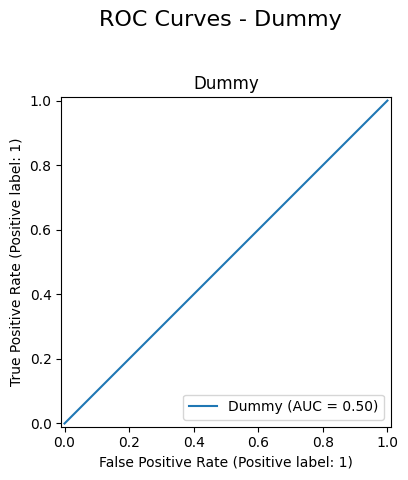

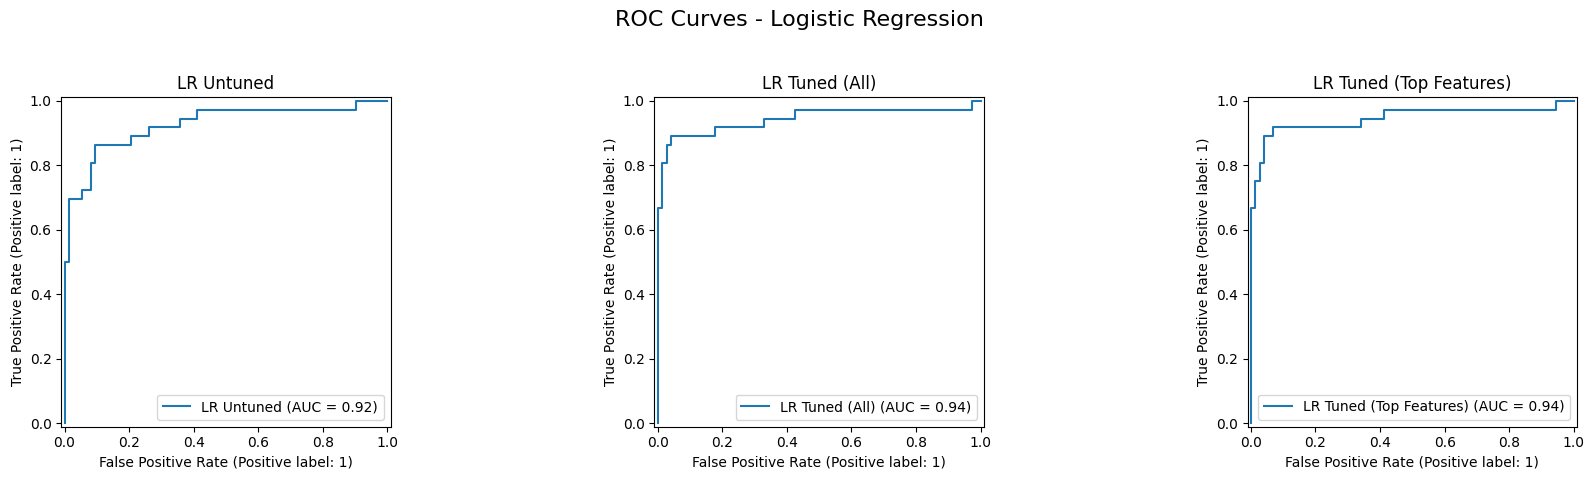

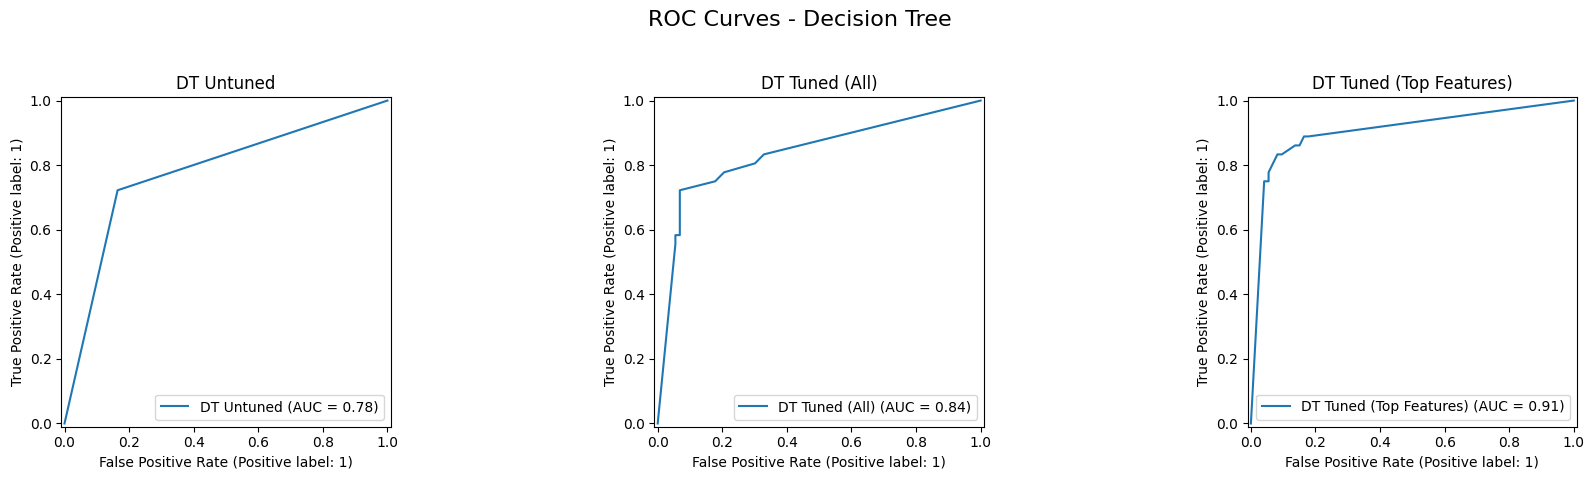

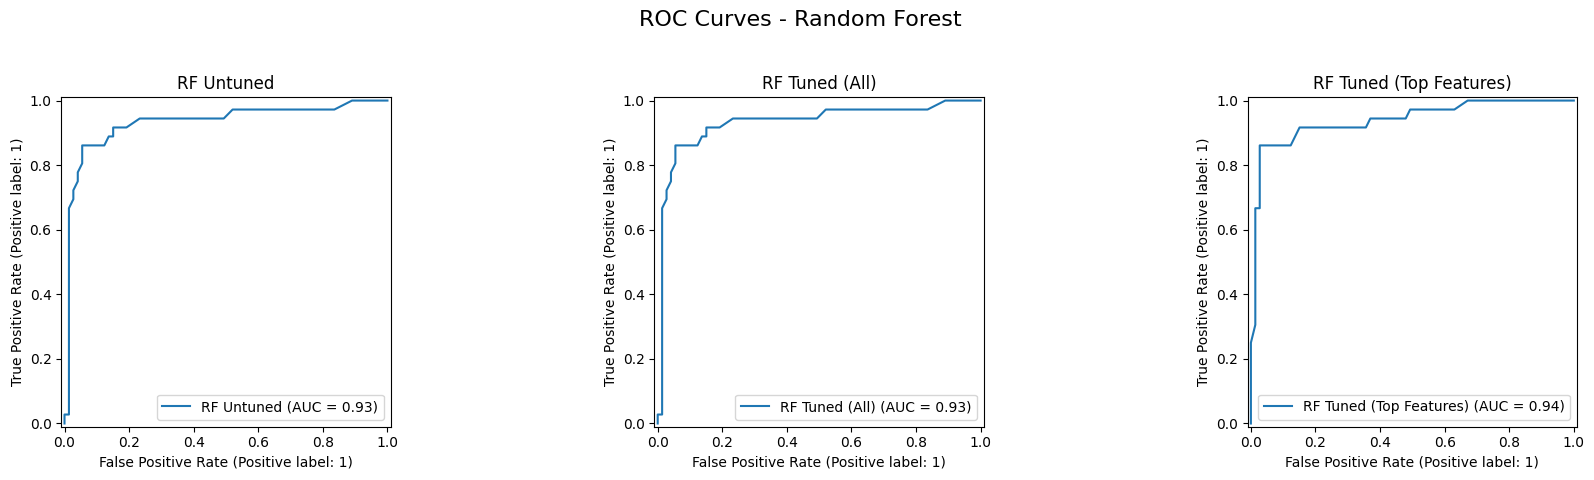

In [ ]:
# Plot all model groups with subplots: each group in one row
for group_name, models in model_groups.items():
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 5))
    fig.suptitle(f"ROC Curves - {group_name}", fontsize=16)

    if n_models == 1:
        axes = [axes]  # Make axes iterable for single model

    for ax, (name, model) in zip(axes, models):
        if hasattr(model, "predict_proba"):
            X_eval = X_test_map.get(name, X_test)
            RocCurveDisplay.from_estimator(model, X_eval, y_test, ax=ax, name=name)
            ax.set_title(name)
        else:
            ax.set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Precision-Recall Curve

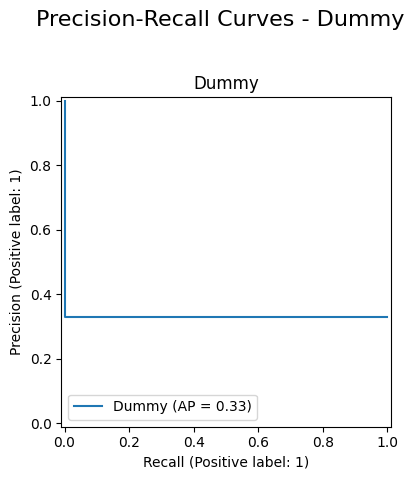

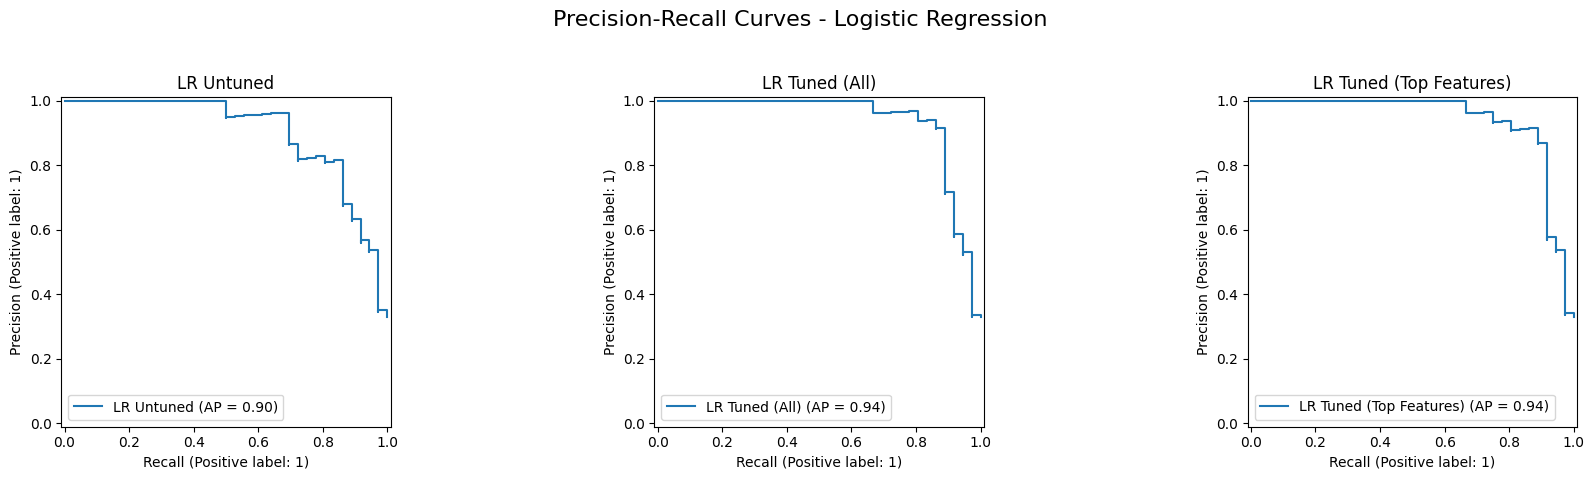

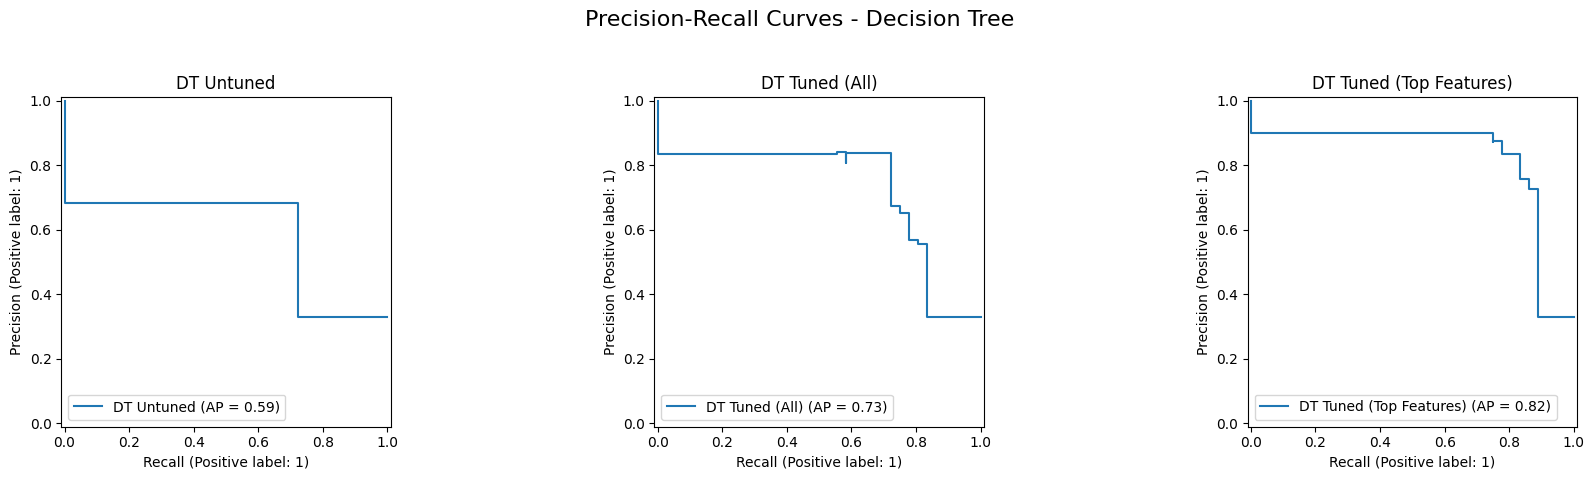

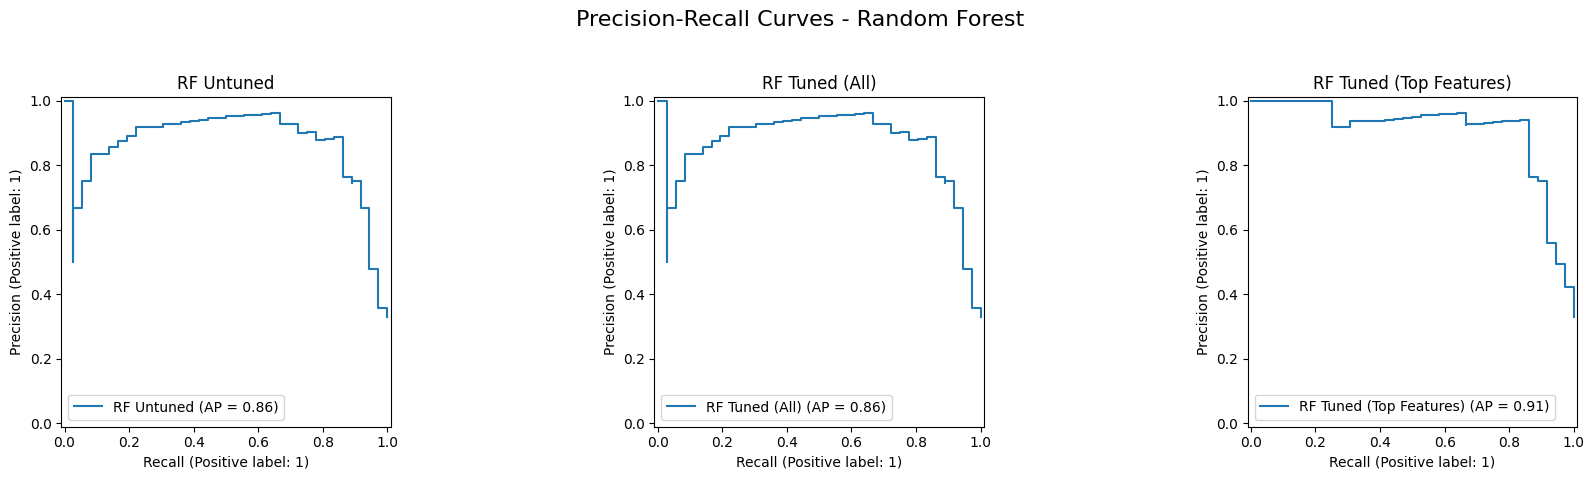

In [ ]:
# Plot Precision-Recall curves for each group in one row
for group_name, models in model_groups.items():
    n = len(models)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
    fig.suptitle(f"Precision-Recall Curves - {group_name}", fontsize=16)

    if n == 1:
        axes = [axes]  # Ensure iterable

    for ax, (name, model) in zip(axes, models):
        if hasattr(model, "predict_proba"):
            X_eval = X_test_map.get(name, X_test)
            PrecisionRecallDisplay.from_estimator(model, X_eval, y_test, ax=ax, name=name)
            ax.set_title(name)
        else:
            ax.set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



## Learning curve

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        X,
        y,
        cv=5,
        scoring='recall_weighted',
        n_jobs=-1,
        train_sizes=np.linspace(0.5, 1.0, 6),  # Start at 50% of training set
        shuffle=True,
        random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(6,4))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Recall')
    plt.plot(train_sizes, val_mean, 'o-', label='Cross-Validation Recall')
    plt.title(title)
    plt.xlabel('Training Set Size')
    plt.ylabel('Recall (Weighted)')
    plt.legend()
    plt.grid(True)
    plt.show()


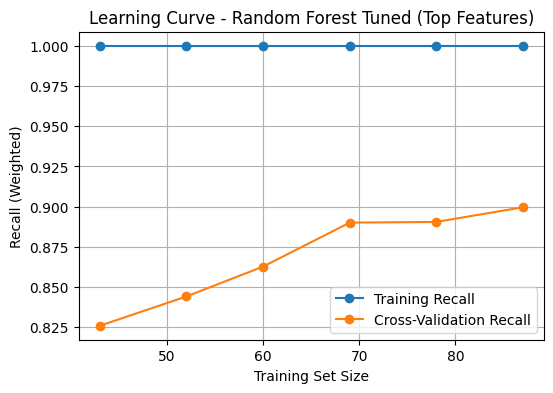

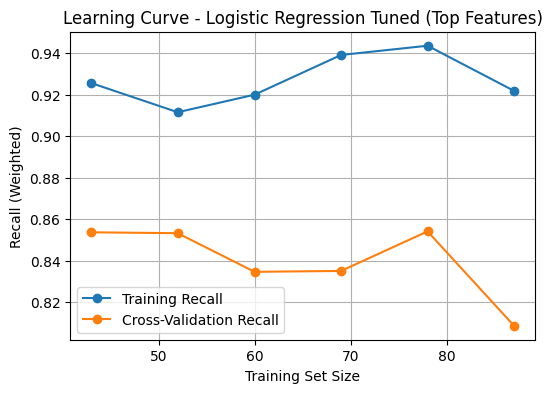

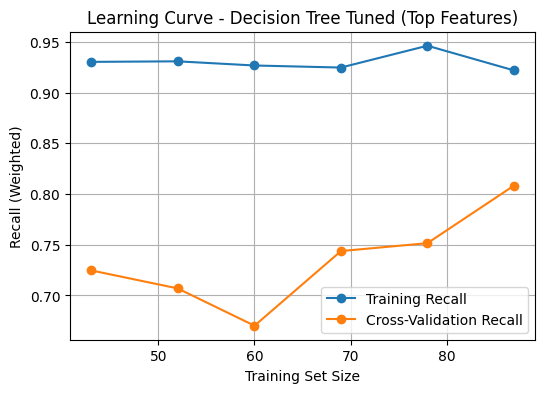

In [ ]:
plot_learning_curve(
    estimator=rf_tuned_pipeline_top_features,
    X=X_test_best_rf,
    y=y_test,
    title='Learning Curve - Random Forest Tuned (Top Features)'
)
plot_learning_curve(
    estimator=lr_pipeline_tuned_top_features,
    X=X_test_best_lr,
    y=y_test,
    title='Learning Curve - Logistic Regression Tuned (Top Features)'
)

plot_learning_curve(
    estimator=dt_tuned_pipeline_top_features,
    X=X_test_best_dt,
    y=y_test,
    title='Learning Curve - Decision Tree Tuned (Top Features)'
)